## Notebook de visualisation des données avec le module MNE
- Visualisation des signaux EEG bruts en fonction du temps avec différents filtrages
- Visualisation des premières composantes ICA. 
    - Visualisation des signaux EEG après avoir retirer / ou garder certaines composantes.
- Visualisation des évènements : Flexion / Extension (pourquoi flexion extension ? : c'était juste en guise de test à un moment ou la labélisation n'était pas encore complète) (à faire sur le mouvement et non-mouvement)
- Visualisation des époques : On affiche les plots des époques en fonction du temps avec en couleur l'intensité des EEG. 


L'idée c'est aussi de comparer les données du patient 4 qui a des bonnes caractéristiques vis à vis du mouvement avec des données d'autres patients.

Pour en apprendre plus sur la visualisation des données EEG à l'aide du module MNE ces deux vidéos de la chaîne "EEG & MEG :: [Brain-Computer Interfaces]" sont hyper simples et claires.
- https://www.youtube.com/watch?v=IYuAPisoUeI&t=5s
- https://www.youtube.com/watch?v=wNIaT1UT6rI




In [1]:
""" Listes des différentes electrodes dont on aura besoin """

electrodes_R = [
     'Fz', 'F2', 'F4', 'F6', 'F8',
    'FCz','FC2','FC4','FC6','FT8', 
     'Cz', 'C2', 'C4', 'C6', 'T8',
    'CPz','CP2','CP4','CP6','TP8',
     'Pz', 'P2', 'P4', 'P6', 'P8',
]

electrodes_L = [
     'Fz', 'F1', 'F3', 'F5', 'F7',
    'FCz','FC1','FC3','FC5','FT7', 
     'Cz', 'C1', 'C3', 'C5', 'T7',
    'CPz','CP1','CP3','CP5','TP7',
     'Pz', 'P1', 'P3', 'P5', 'P7',
]

motor_electrods_d = ['FC2', 'FC4', 'FC6', 
                         'C2', 'C4', 'C6',
                         'CP2', 'CP4', 'CP6']

motor_electrods_g = ['FC1', 'FC3', 'FC5',
                          'C1', 'C3', 'C5',
                          'CP1', 'CP3', 'CP5']

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne

from preprocessing.data_loader import DataLoader
from scipy import signal
from scipy.fft import fft, ifft, fftfreq
from sklearn.decomposition import PCA

ModuleNotFoundError: No module named 'preprocessing'

In [4]:
"""
Patients intéressants: 004, 102 (pourquoi ? We don't know)
"""

'\nPatients intéressants: 004, 102\n'

In [4]:
FILE_PATH_TRIAL = '../../data/raw/DATA_004_Trial1.npy'
loader_trial = DataLoader(FILE_PATH_TRIAL)
side_of_motor_arm = "G"
raw_g = loader_trial.get_raws(side = side_of_motor_arm)
raw_d = loader_trial.get_raws(side = 'D')

In [6]:
# 1er Filtrage entre 1 Hz et 60 Hz
raw_g.filter(l_freq =1,h_freq = 60)
raw_d.filter(l_freq =1,h_freq = 60)

<RawArray | 70 x 229827 (224.4 s), ~122.8 MB, data loaded>

# ICA : Analyse des composantes indépendantes

L'ICA est utile pour retirer certains artefacts comme le clignement des yeux. 
Nous ne l'avons pas utilisé dans notre pipeline par manque de temps mais il pourrait être envisageable de retirer des artefacts avec cette méthode. Attention cependant à ne pas trop retirer du signal d'intérêt qui pourrait aider à la classication de l'intention de mouvement.

In [5]:

ica_g = mne.preprocessing.ICA(n_components = 20, random_state = 0)
ica_g.fit(raw_g.copy().filter(1,20)) # En filtrant entre 1 Hz et 20 Hz

ica_g_2 = mne.preprocessing.ICA(n_components = 20, random_state = 0)
ica_g_2.fit(raw_g.copy().filter(20, 40)) # En filtrant entre 20 Hz et 40 Hz

ica_g_3 = mne.preprocessing.ICA(n_components = 20, random_state = 0)
ica_g_3.fit(raw_g.copy().filter(10, 30)) # En filtrant entre 10 Hz et 30 Hz

ica_d = mne.preprocessing.ICA(n_components = 20, random_state = 0)
ica_d.fit(raw_d.copy())

<ICA | raw data decomposition, method: fastica (fit in 50 iterations on 229827 samples), 20 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

Le plot suivant montre la répartition spatiale des différentes composantes. La première composante semble correspondre aux clignements des yeux. 
On pourrait tenter de regarder s'il n'y a pas d'autres composantes à identifier facilement.

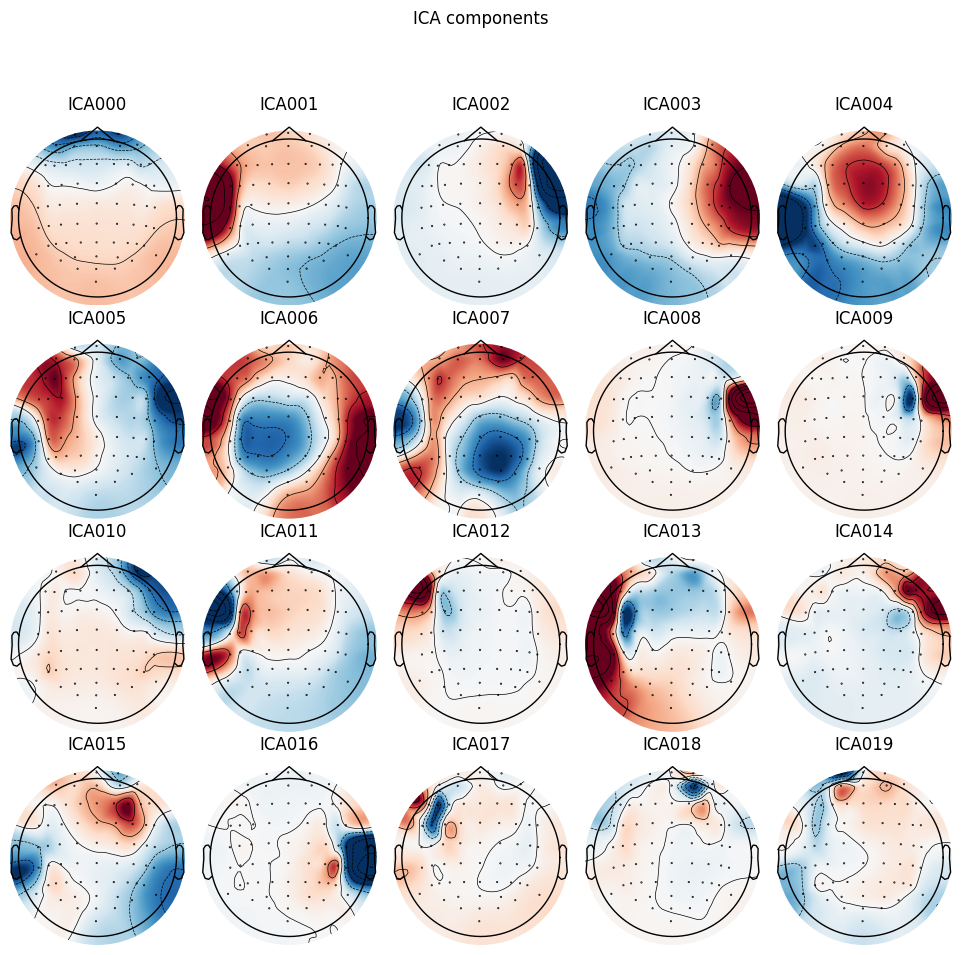

In [8]:
ica_g.plot_components();

In [8]:
# On exclut les composantes qui sont potentiellement dues aux clignements des yeux
def return_exclude(include, nbr_components=20):
    exclude  = list(set(list(range(0,nbr_components))).difference(set(include)))
    return exclude

# ica_g.exclude = return_exclude([4]) # On veut voir le signal correspondant uniquement à la composante 4
ica_g.exclude = [0] # On retire le clignement des yeux
# ica.exclude = list(range(15))
raw_g = ica_g.apply(raw_g.copy(),exclude=ica_g.exclude)

# On récupère les évènements Flexion & Extension

Dans cette partie, on s'intéresse à la différence des données de flexion et d'extension.

19 events found
Event IDs: [1 2]
19 events found
Event IDs: [1 2]


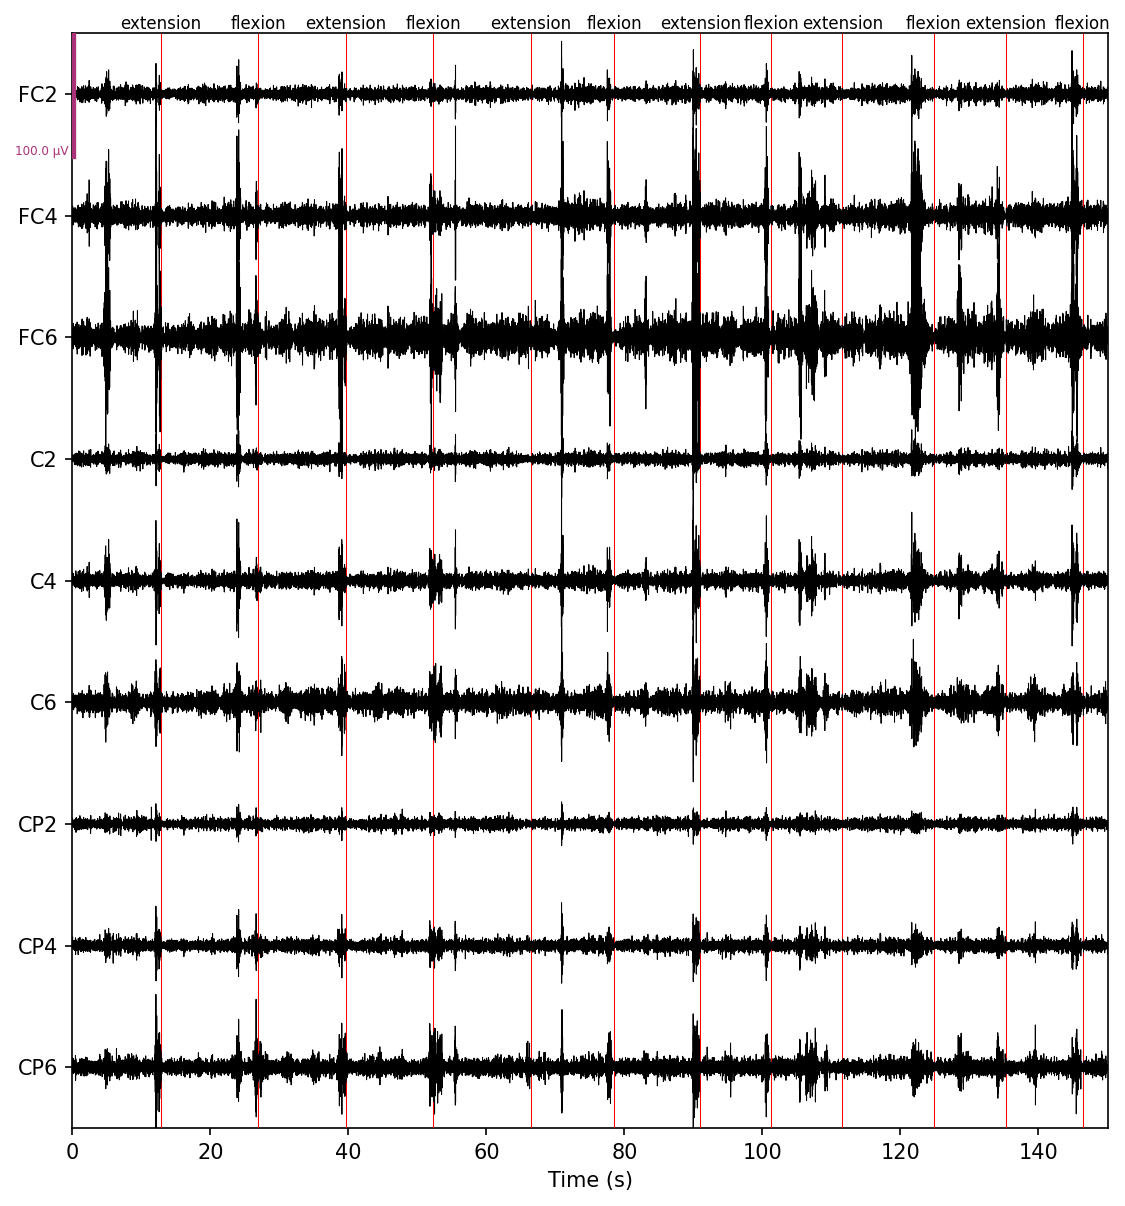

In [9]:
from mne import find_events

# Récupération des évènements de flexion et d'extension
events_g = find_events(raw_g, stim_channel="movement",shortest_event=0, verbose=True)
events_d = find_events(raw_d, stim_channel="movement",shortest_event=0, verbose=True)
event_ids = dict(extension = 1, flexion = 2)
event_colors = dict(red = 1, blue = 2, green=0)
scal = dict(eeg = 5e-5)   

plt.rcParams['figure.dpi'] = 150

raw_g.copy().pick(motor_electrods_d).plot(
           events=events_g, 
           event_color="red", 
           event_id=event_ids,
           scalings= dict(eeg = 5e-5) ,
           clipping=None, 
            show_scrollbars=False,
            show_scalebars=True, 
           start=0,  
           duration=150,   
           lowpass=40, highpass=10,  
           n_channels=10,
           title="Les différentes électrodes avec les débuts de chaque mouvement") 

plt.show()

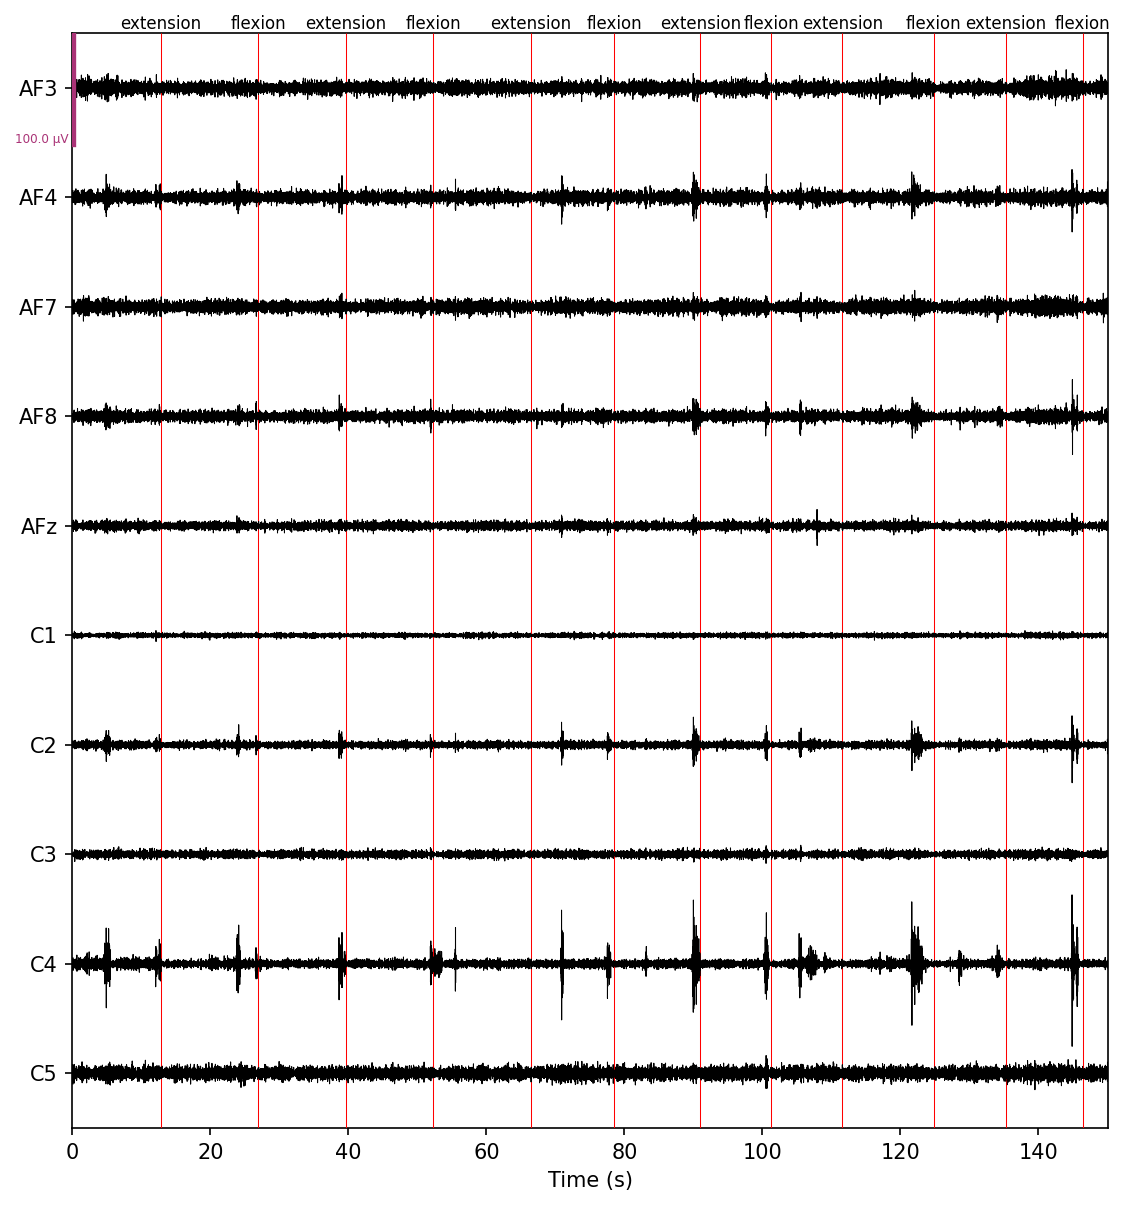

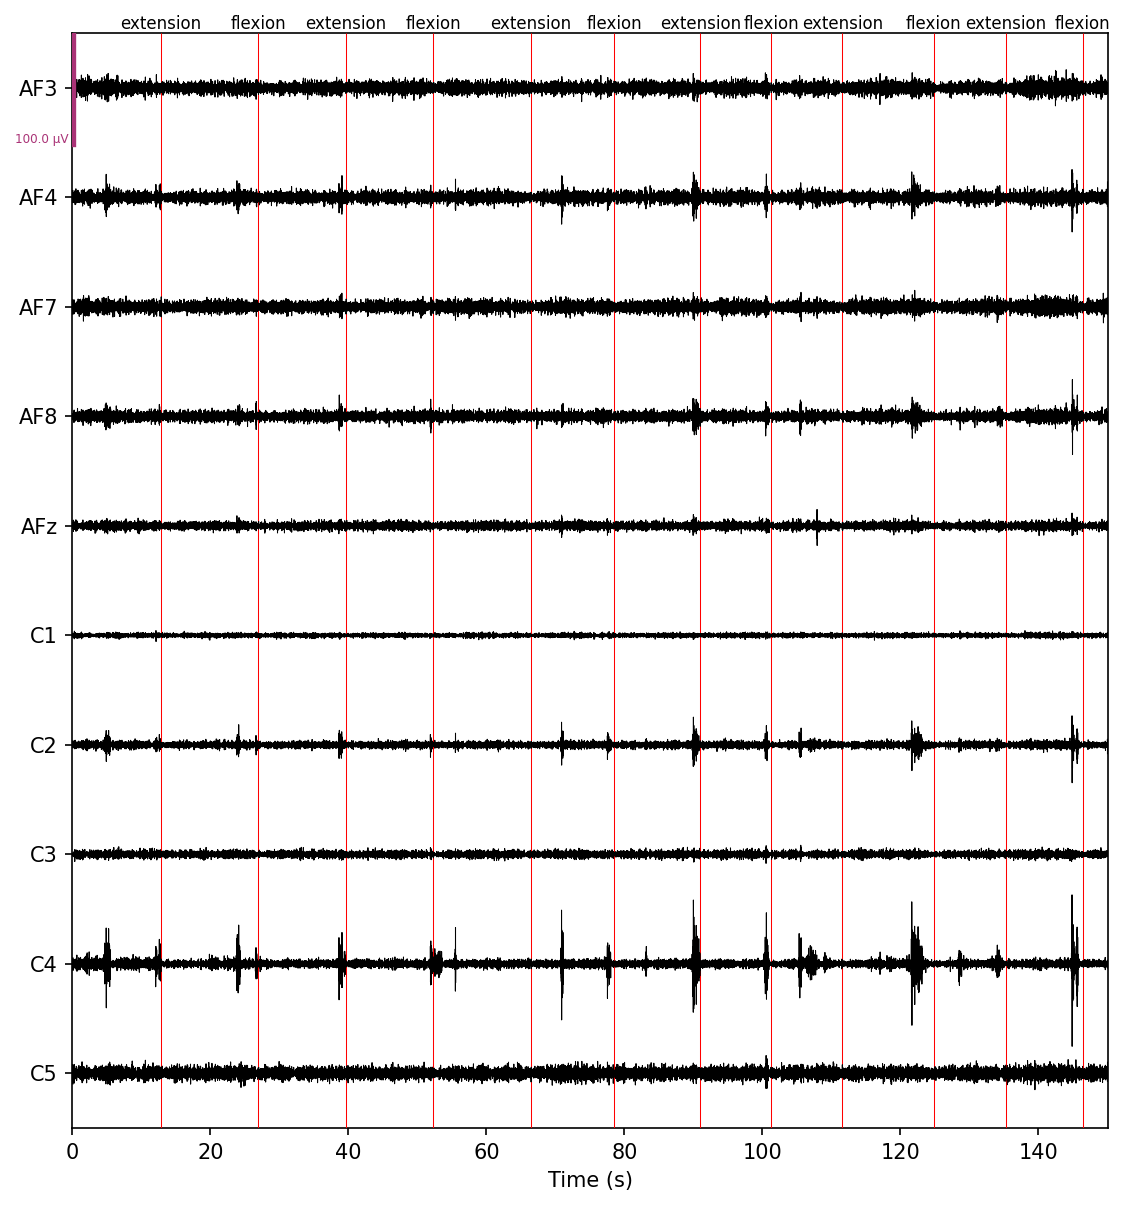

In [12]:
# Visualisation du signal uniquement sur les composantes 2, 7 et 15 

ica_g.apply(raw_g.copy(),exclude=return_exclude([2,7,15])).plot(events=events_g, 
           event_color="red", 
           event_id=event_ids,
           scalings= dict(eeg = 5e-5) ,
           clipping=None, 
            show_scrollbars=False,
            show_scalebars=True, 
           start=0,       # EDIT ME!
           duration=150,   
           lowpass=40, highpass=10,  # EDIT ME!
           n_channels=10,
           title="Les différentes électrodes avec les débuts de chaque mouvement")   # EDIT ME!


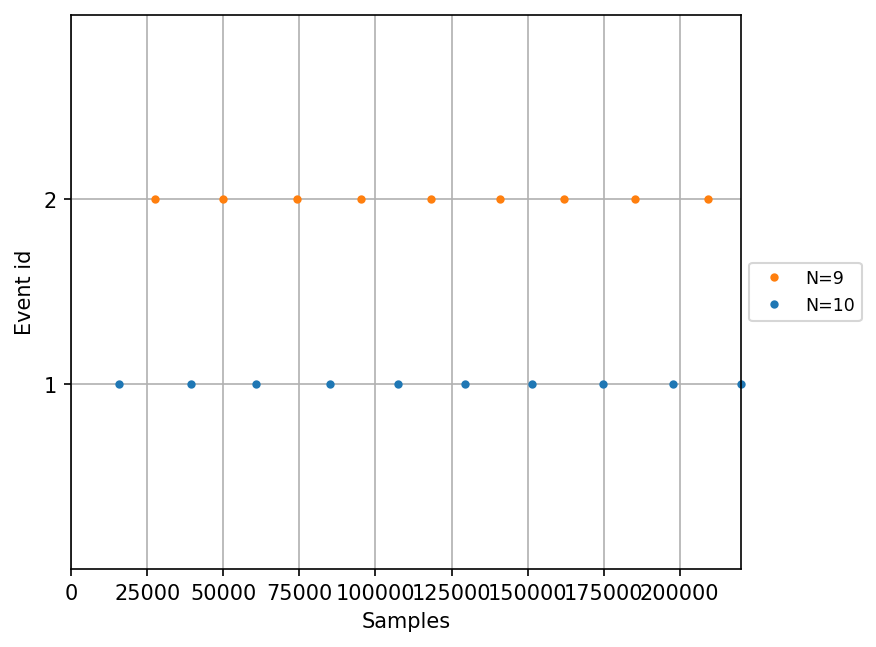

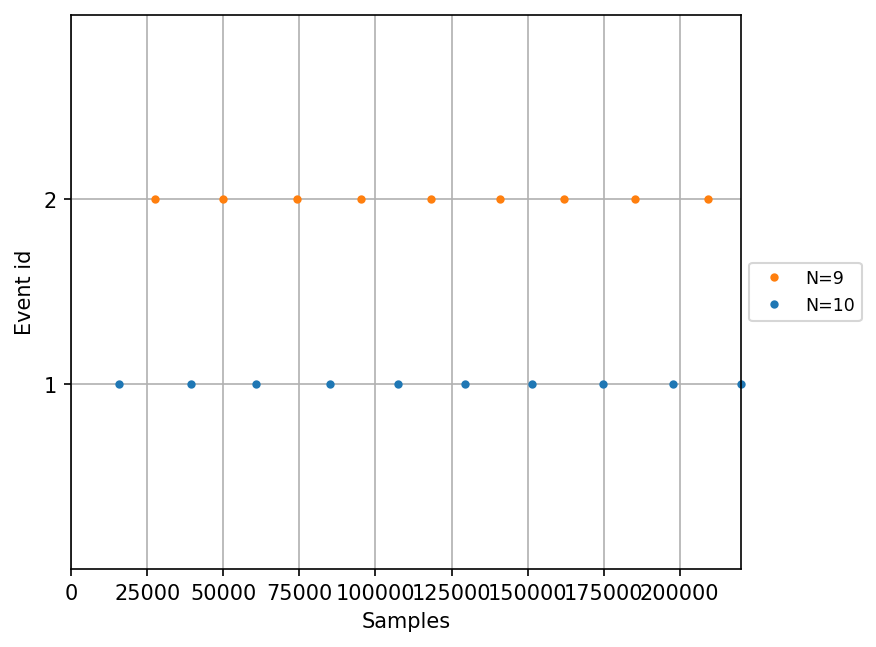

In [14]:
mne.viz.plot_events(events_d[::])

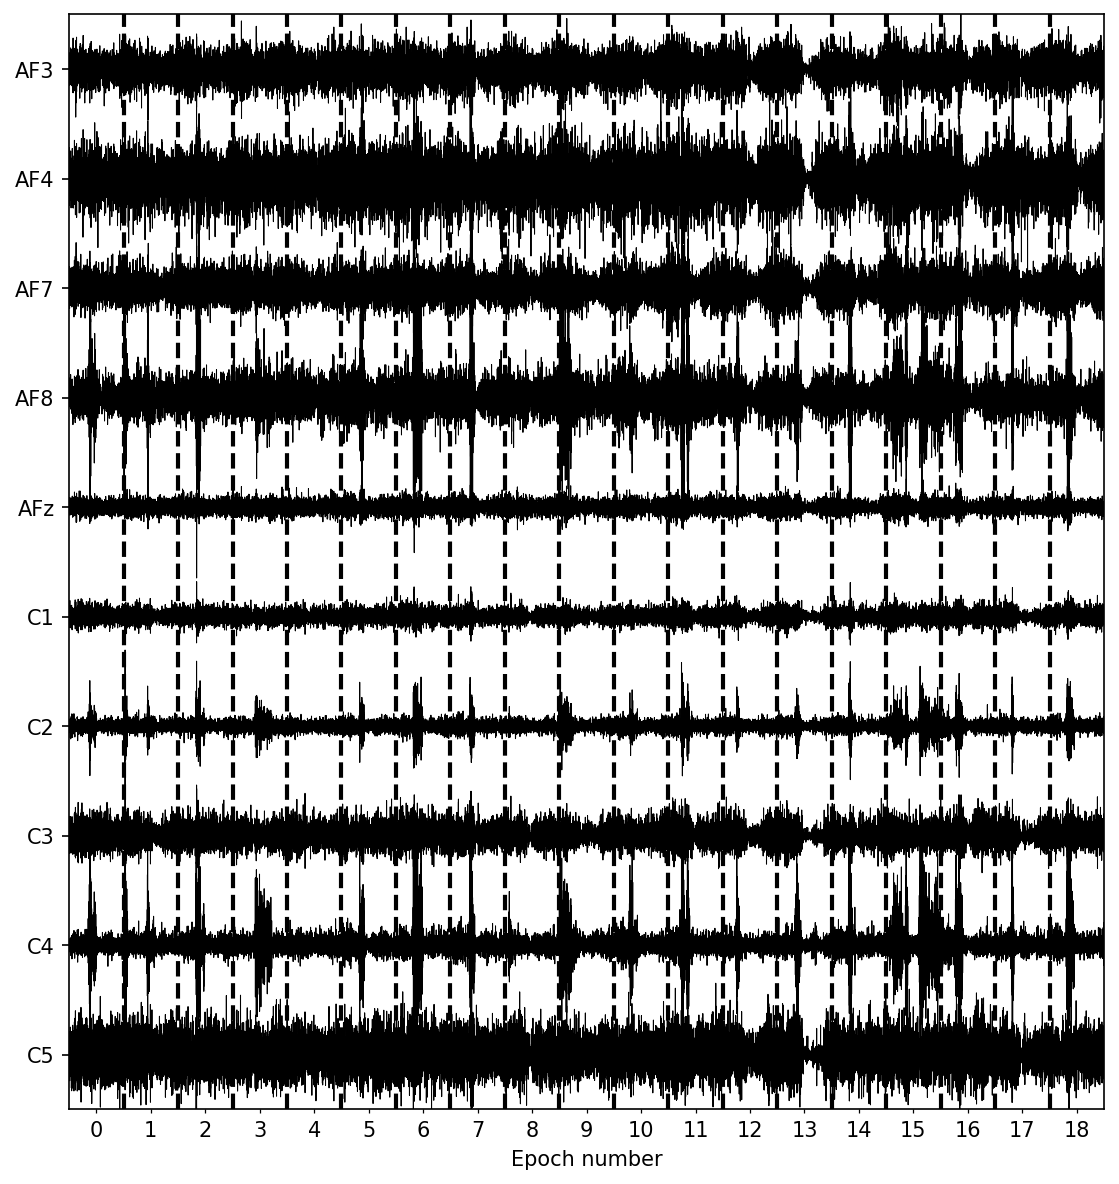

In [21]:
event_ids = dict(extension = 1, flexion = 2)
epochs_g = mne.Epochs(raw_g, events_g, event_id=event_ids,
                    tmin=-3,tmax=3,preload=True)
epochs_d = mne.Epochs(raw_d, events_d, event_id=event_ids,
                    tmin=-3,tmax=3,preload=True)
epochs_g.plot(n_channels=10, scalings= dict(eeg = 5e-5),  
         show_scrollbars=False, show_scalebars=False);

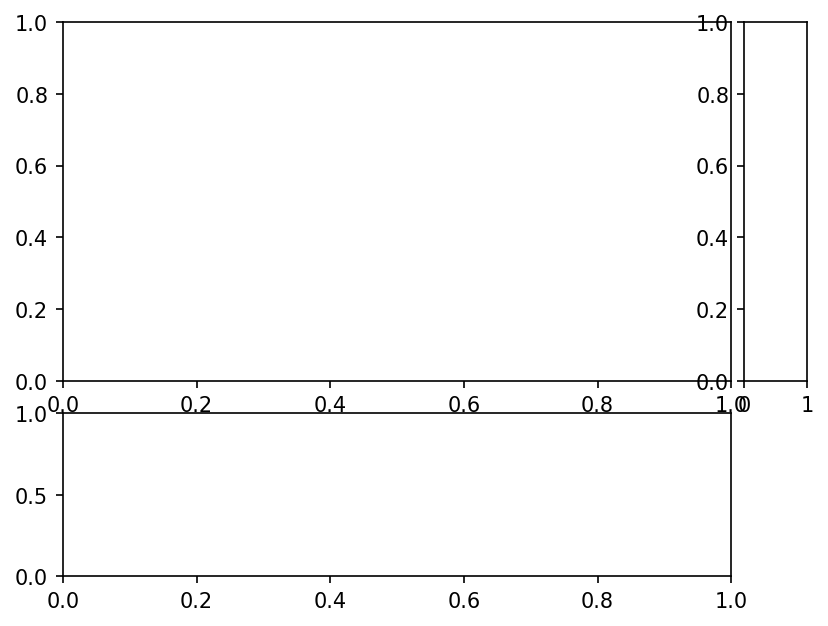

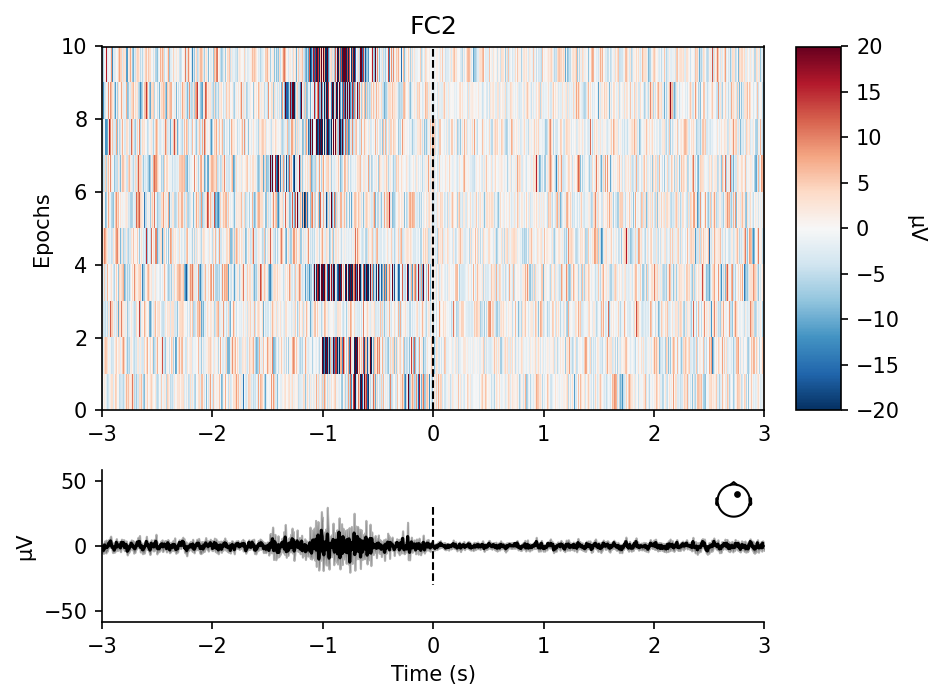

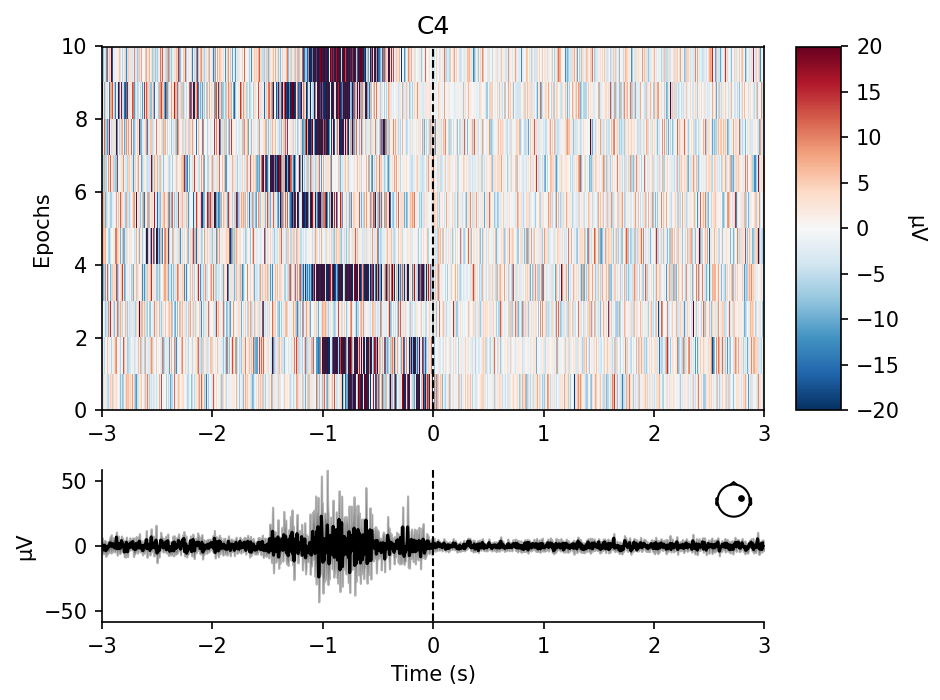

[<Figure size 960x720 with 4 Axes>, <Figure size 960x720 with 4 Axes>]

In [16]:
# Côté non lésé
epochs_g["extension"].plot_image(picks=["FC2","C4"],
                               vmin = -20,
                               vmax = 20)

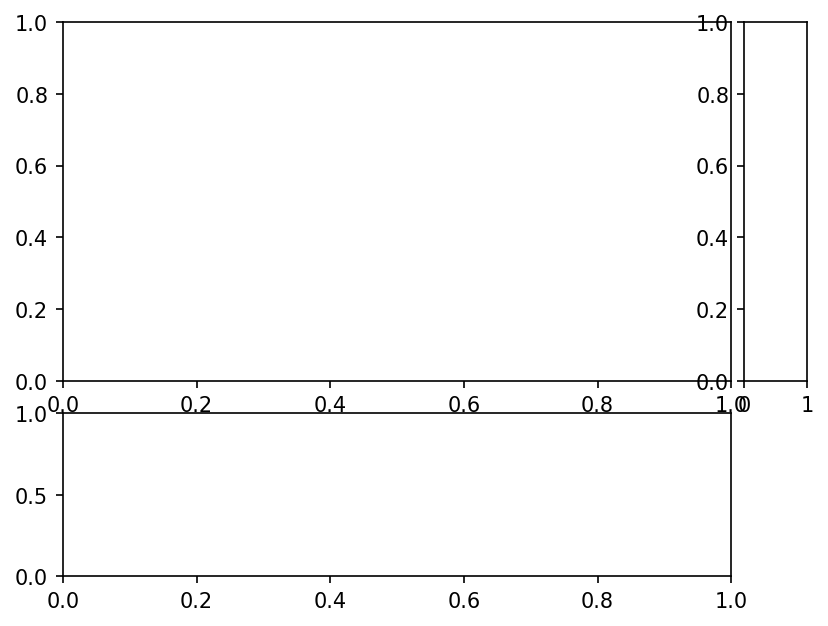

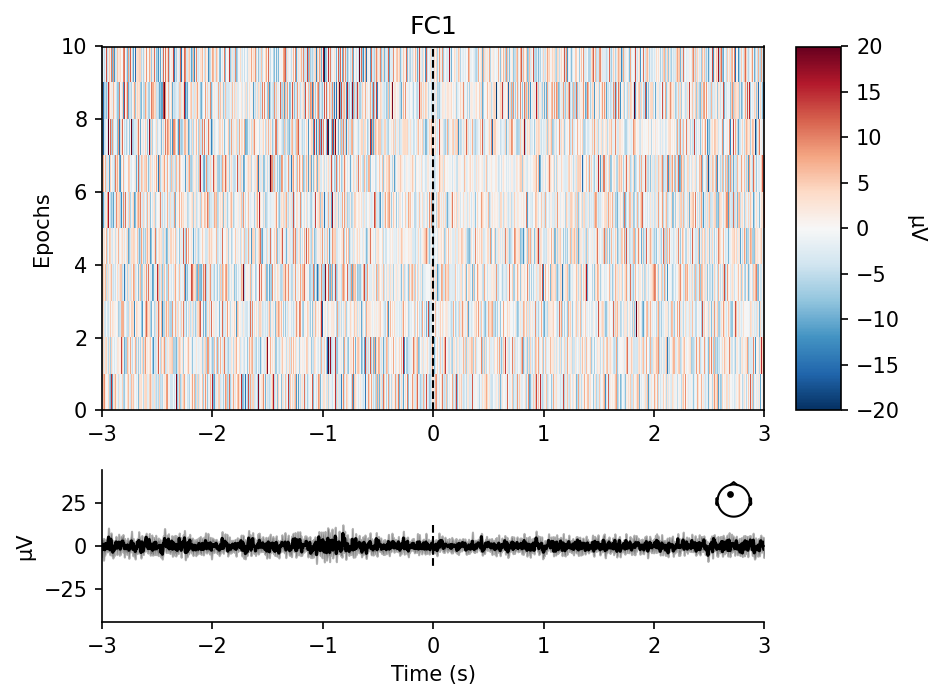

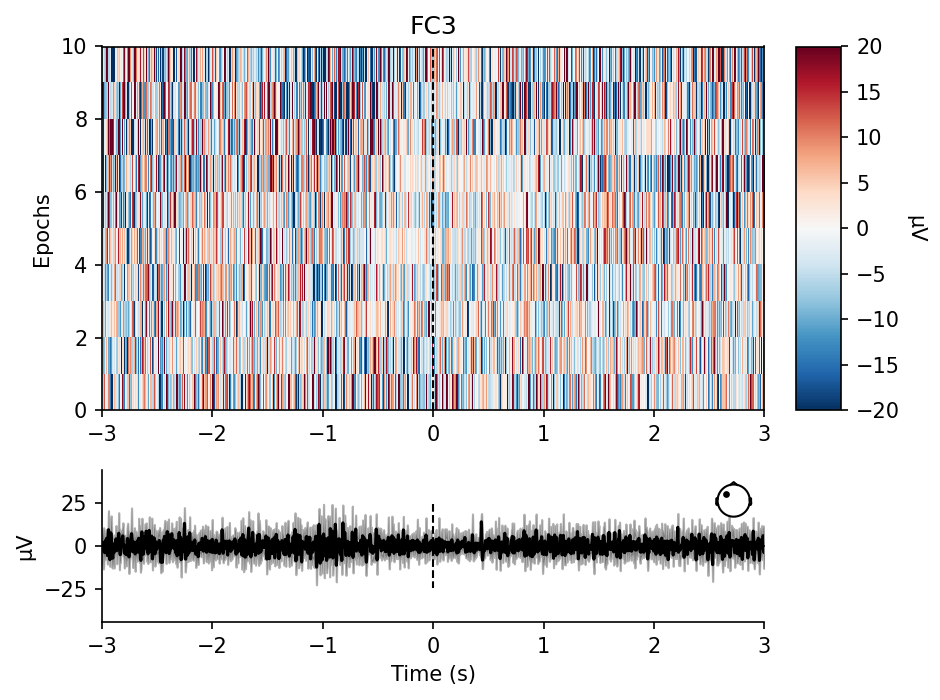

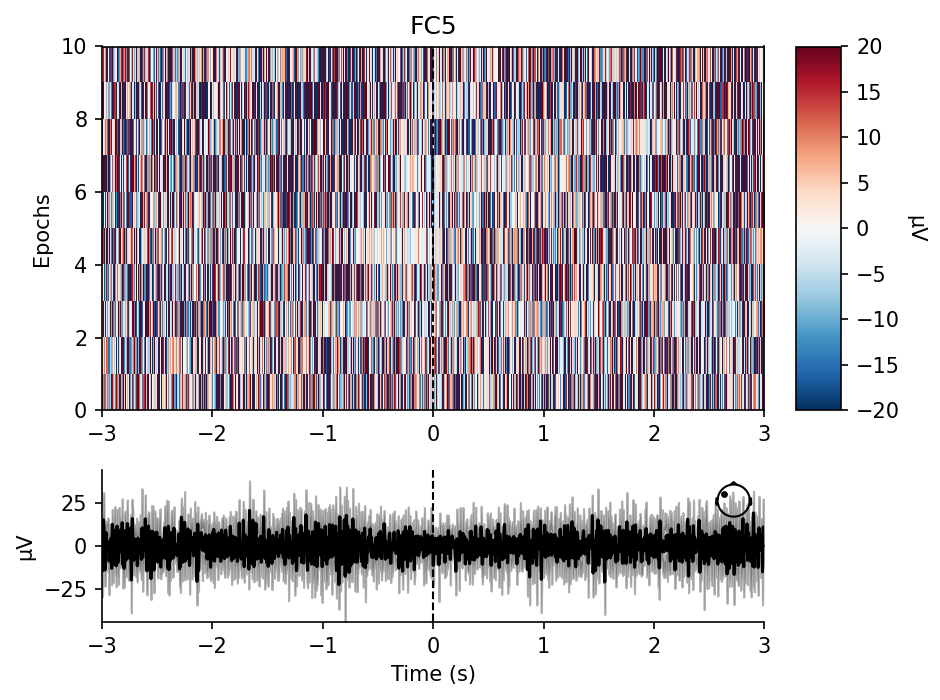

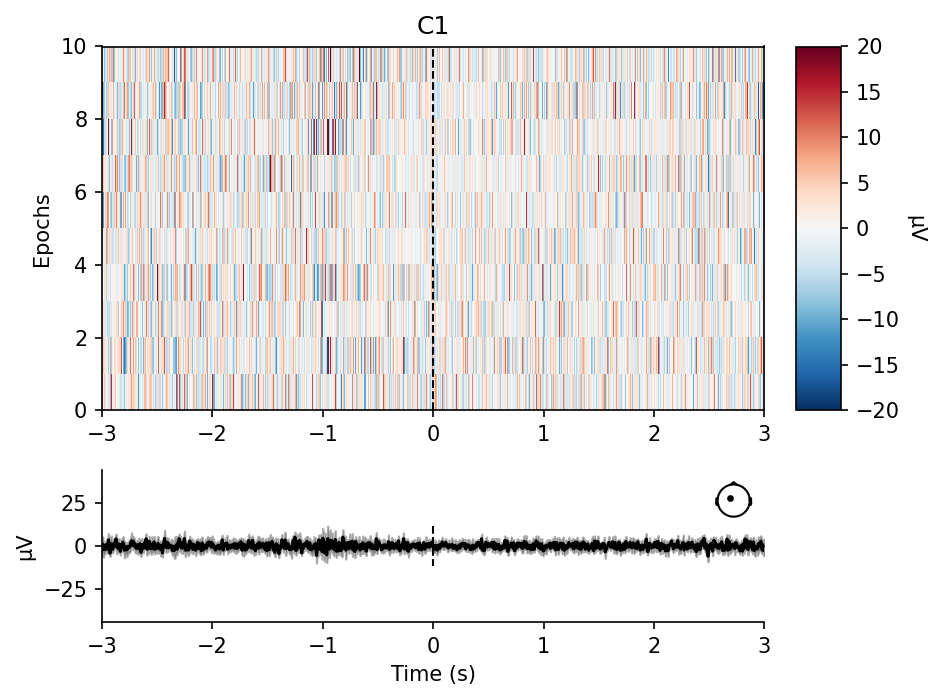

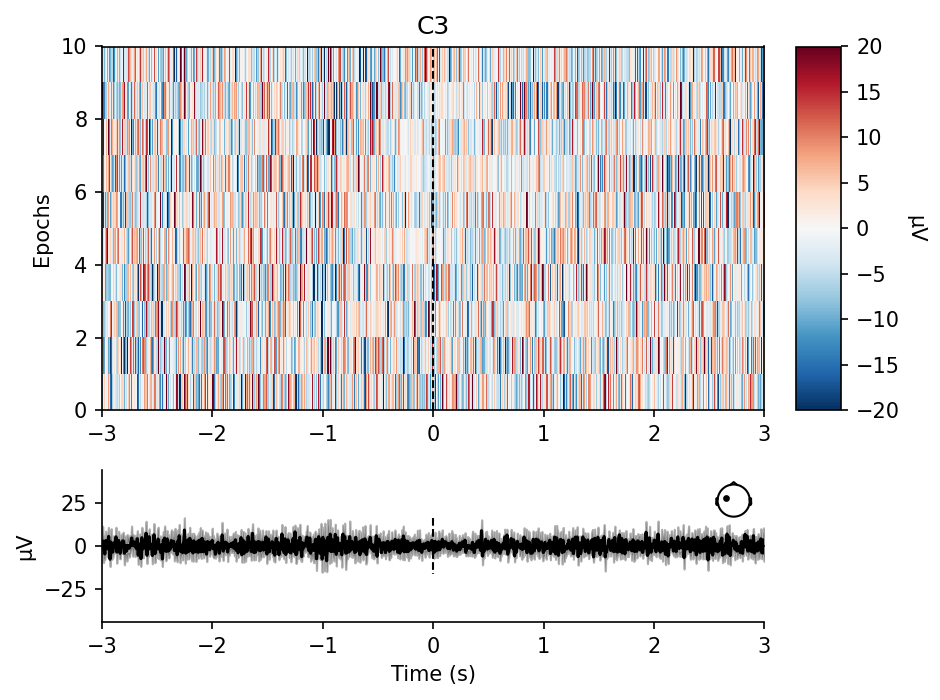

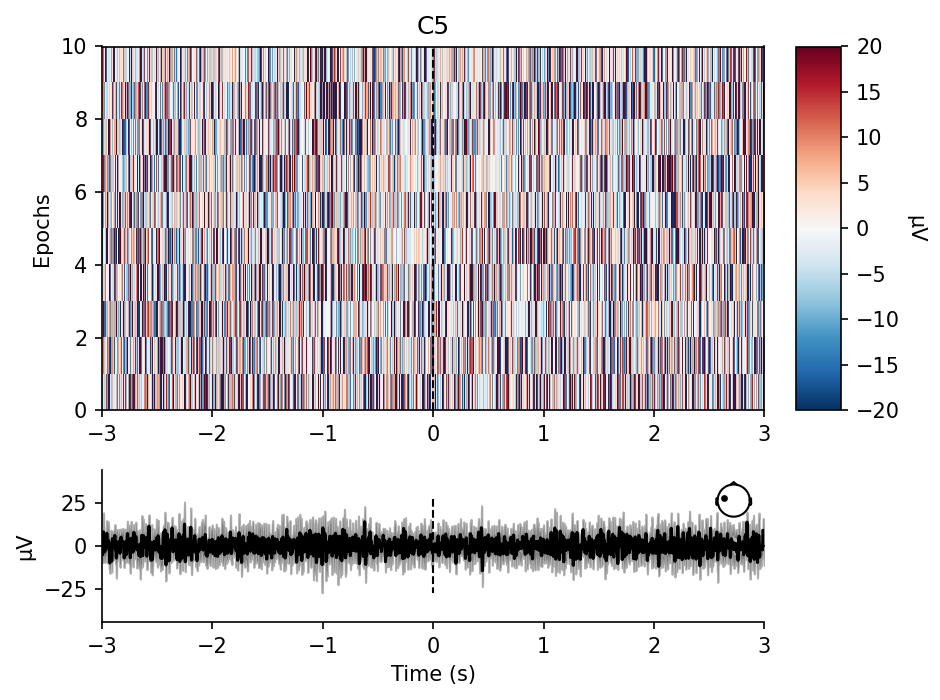

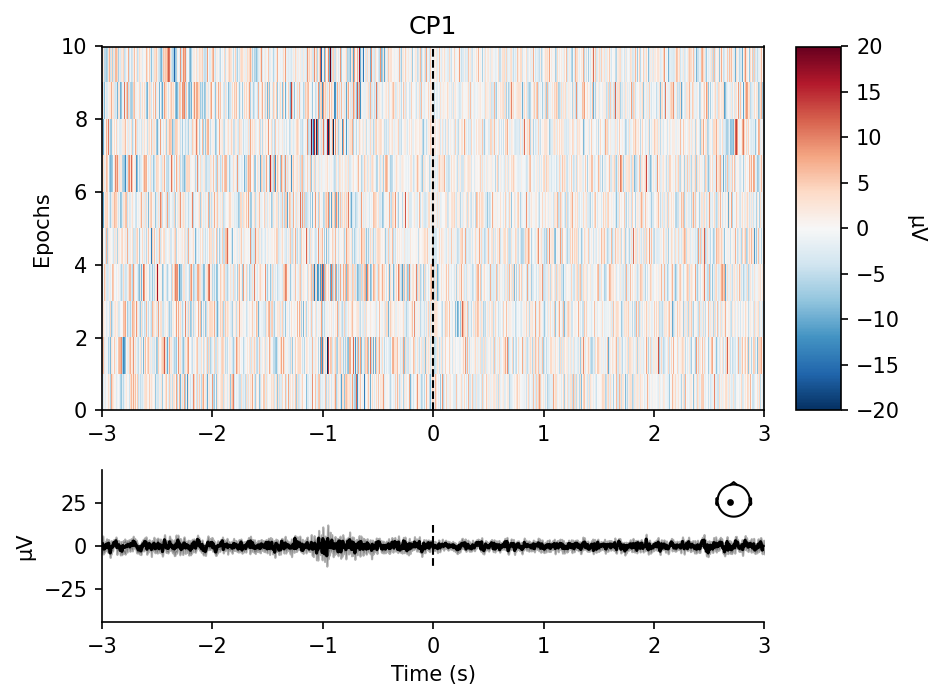

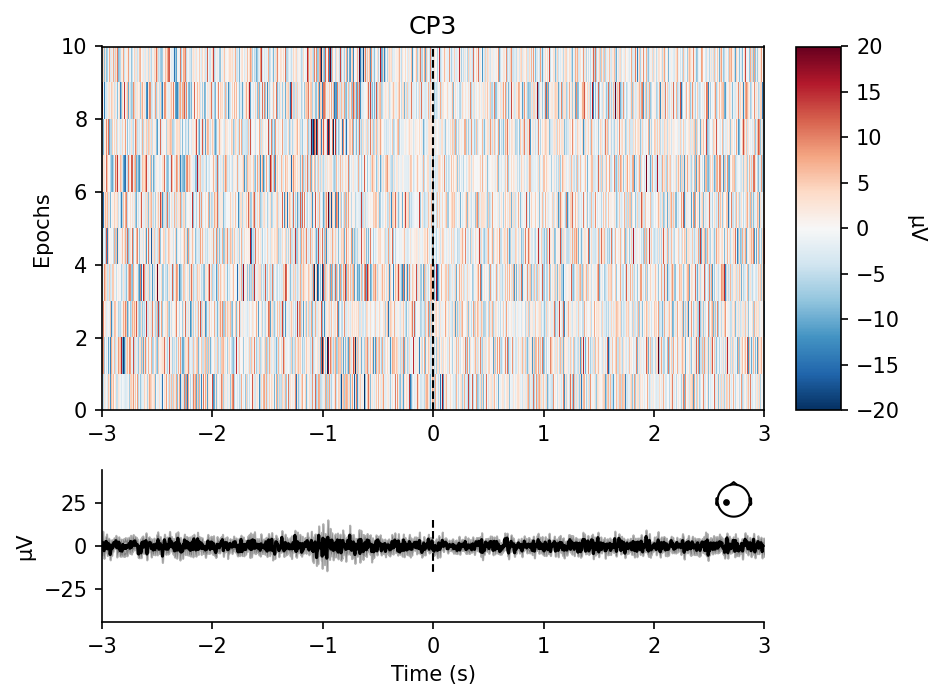

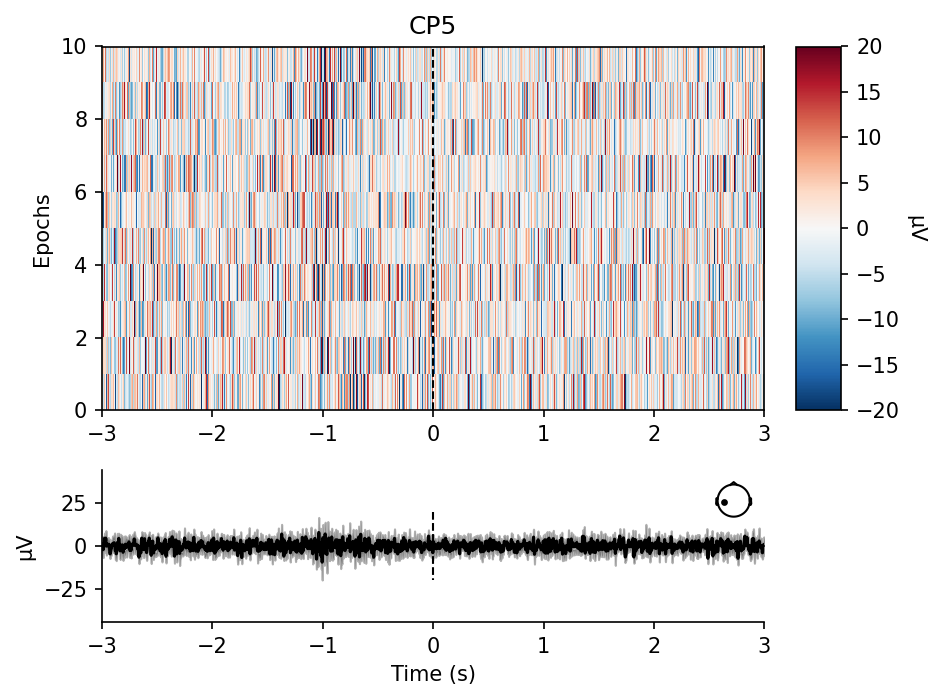

[<Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>]

In [23]:
# Côté lésé
epochs_g["extension"].plot_image(picks=motor_electrods_g,
                               vmin = -20,
                               vmax = 20)

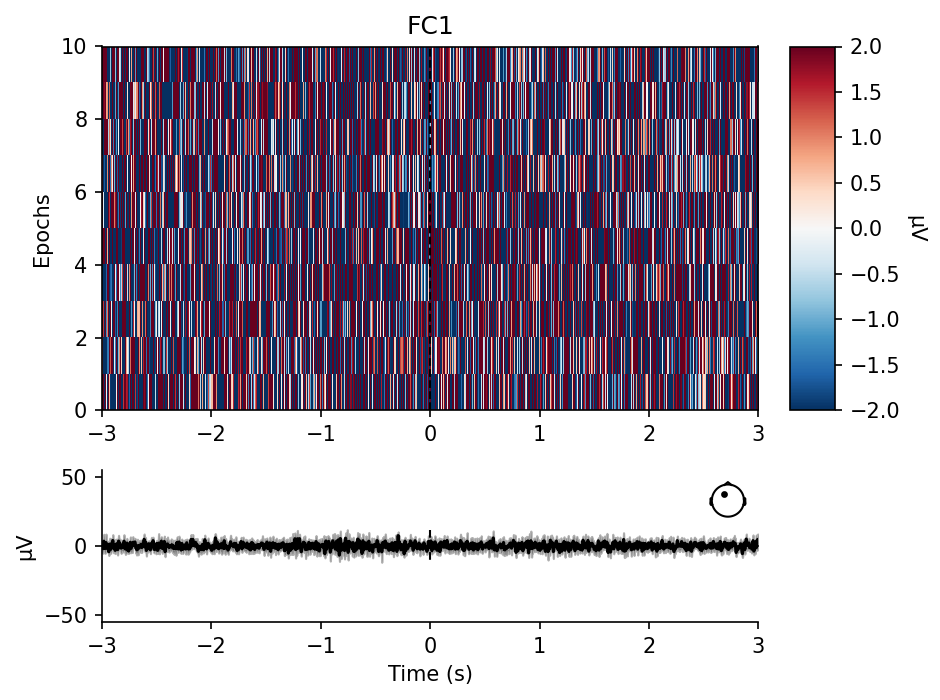

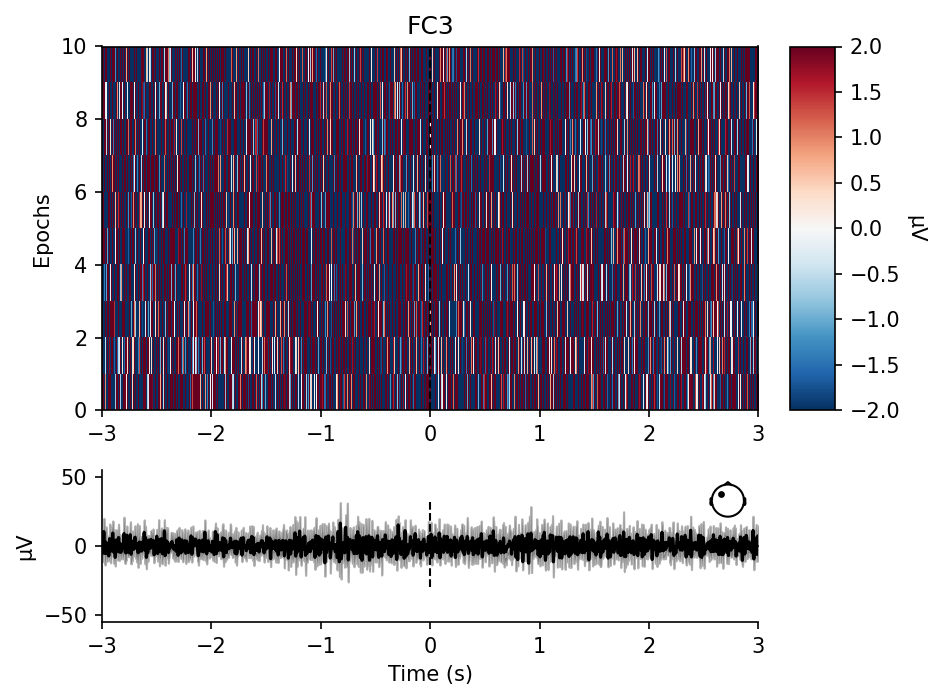

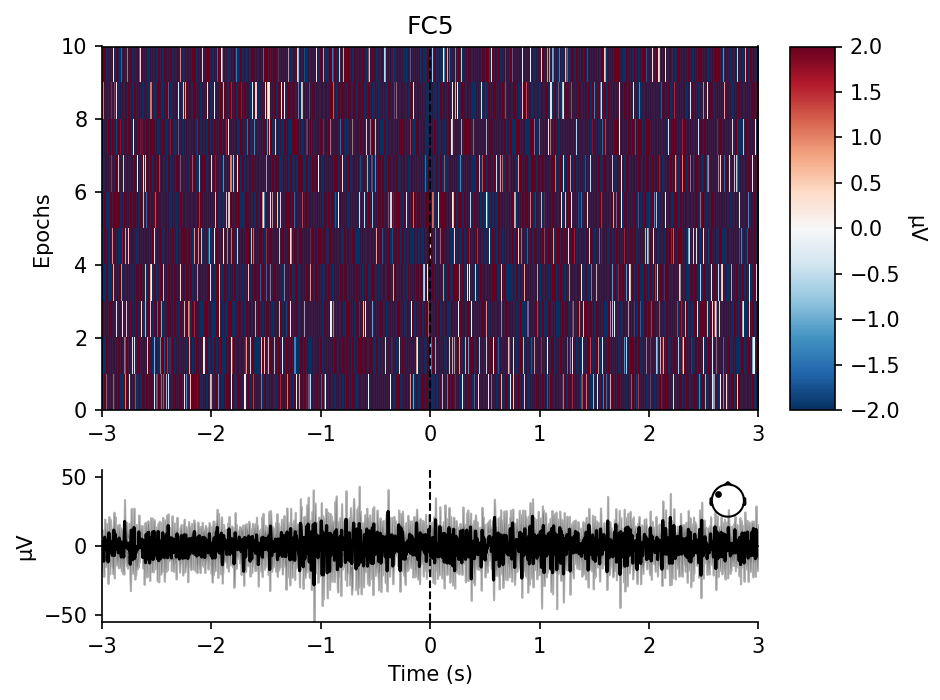

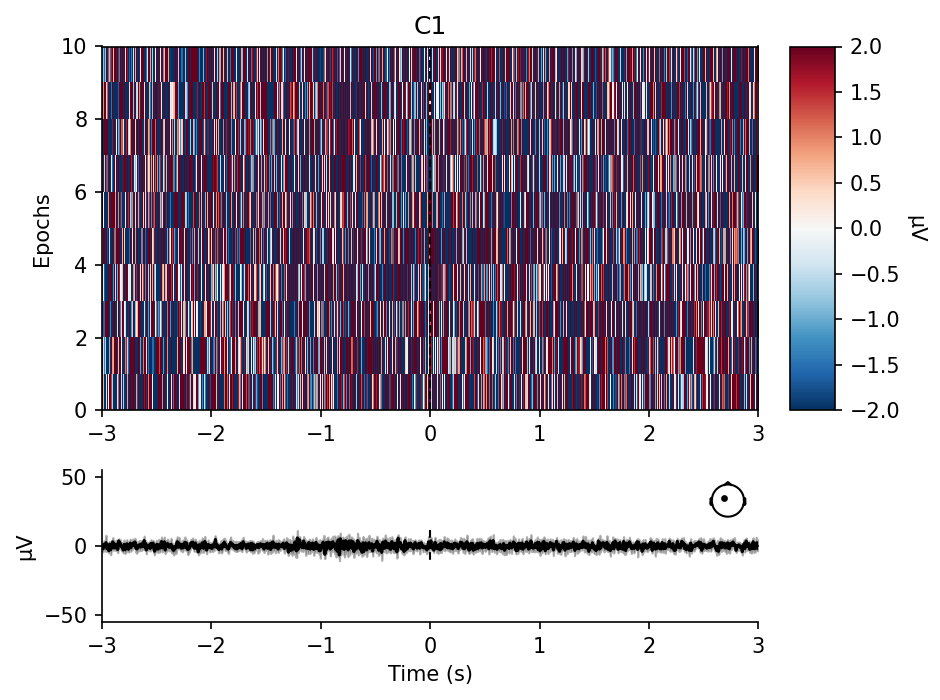

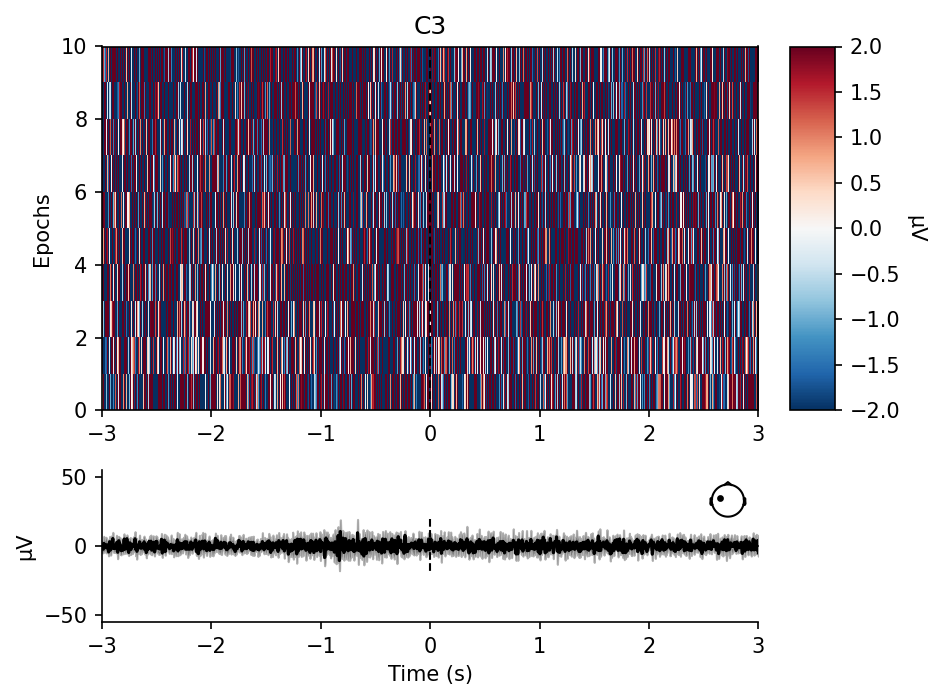

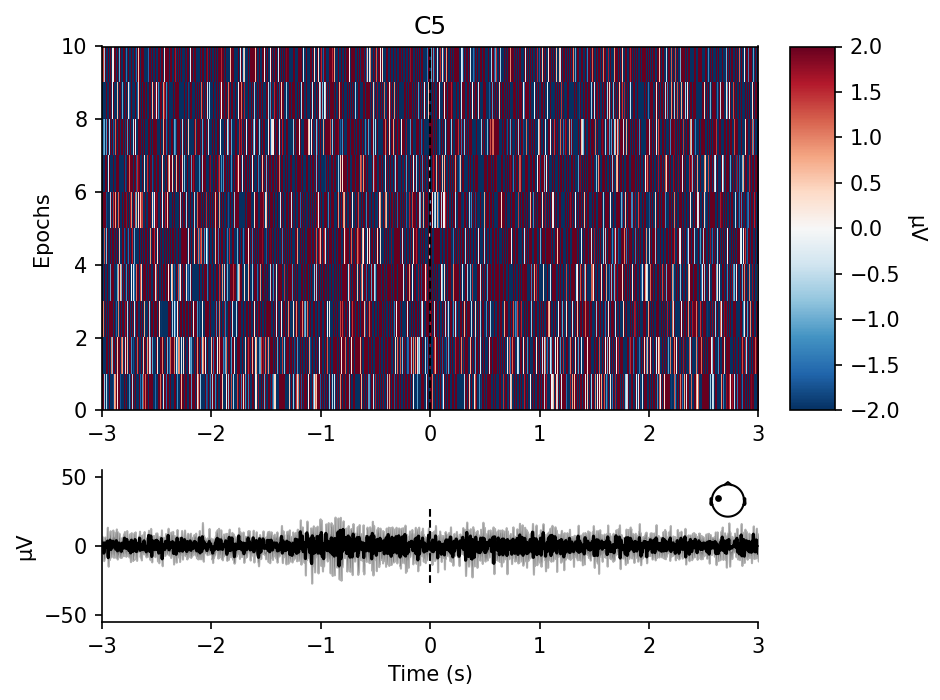

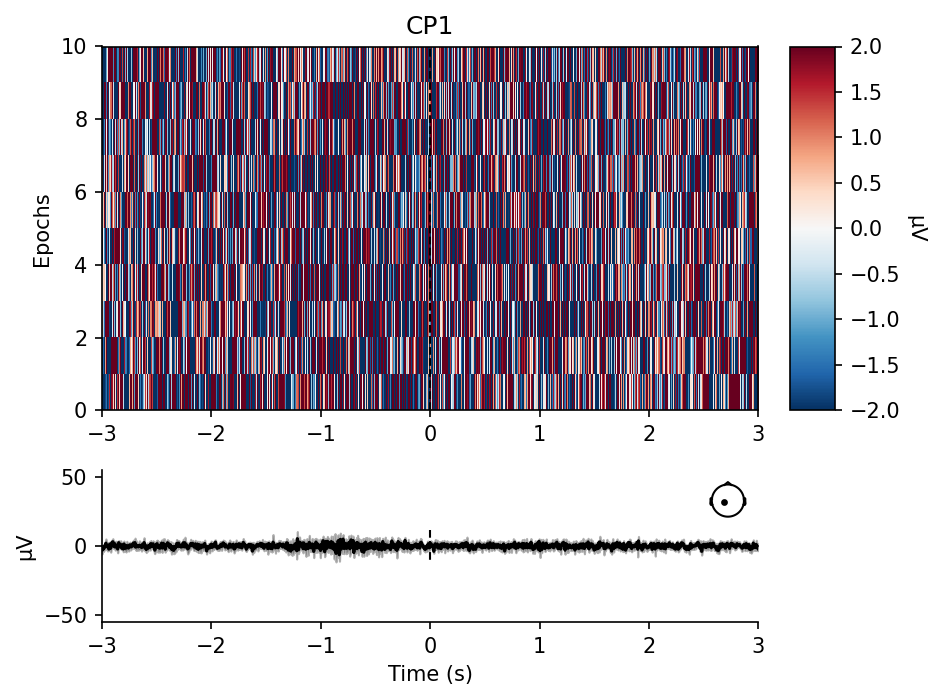

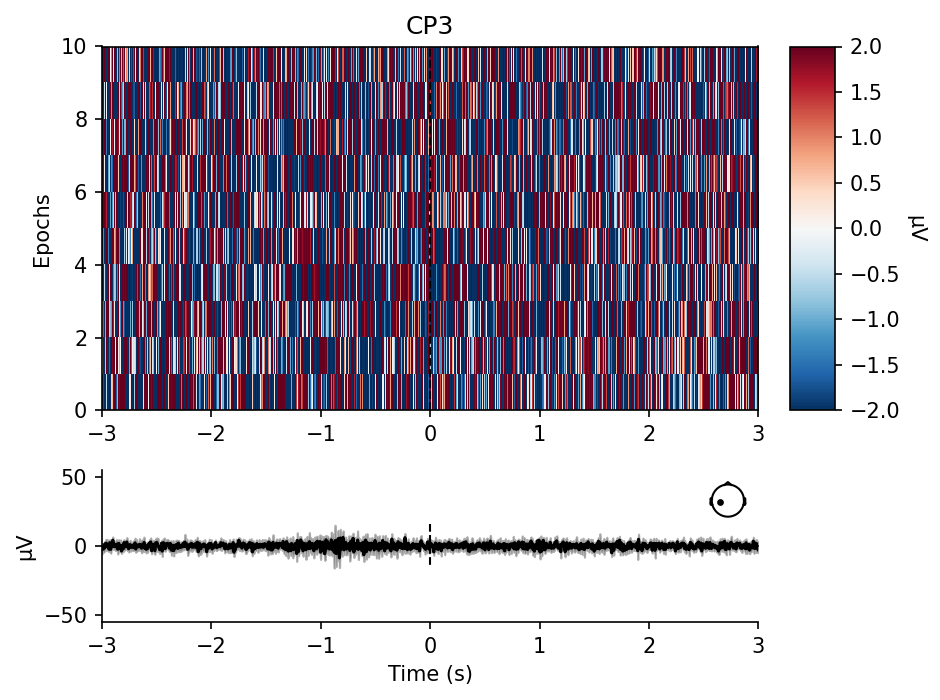

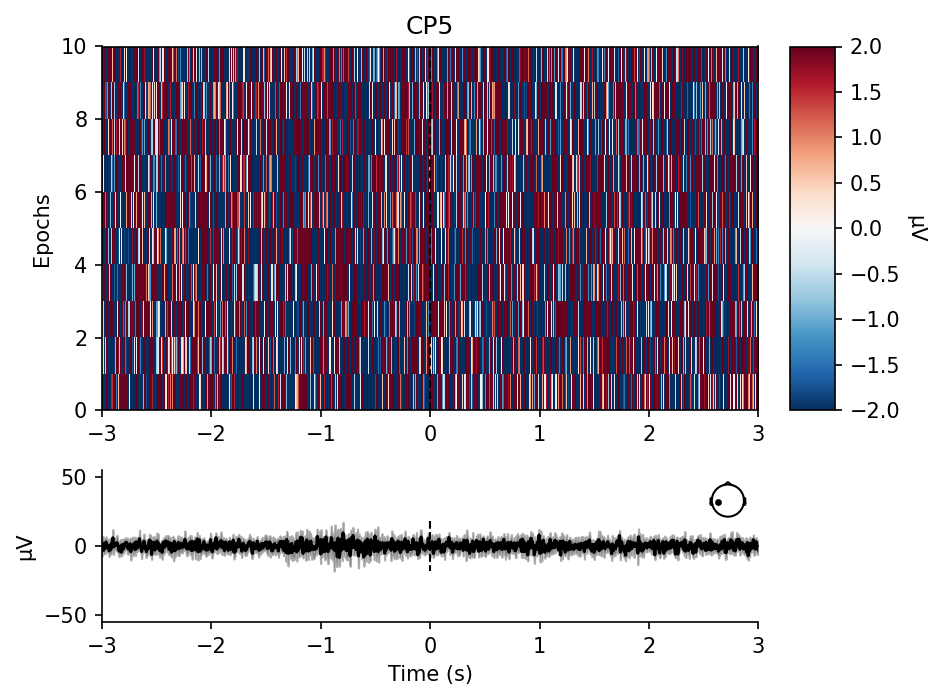

[<Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>]

In [24]:
# On change l'echelle pour le côté lésé --> on a vraiment pas de signal intéréssant (à première vue)
epochs_d["extension"].plot_image(picks=motor_electrods_g,
                               vmin = -2,
                               vmax = 2)

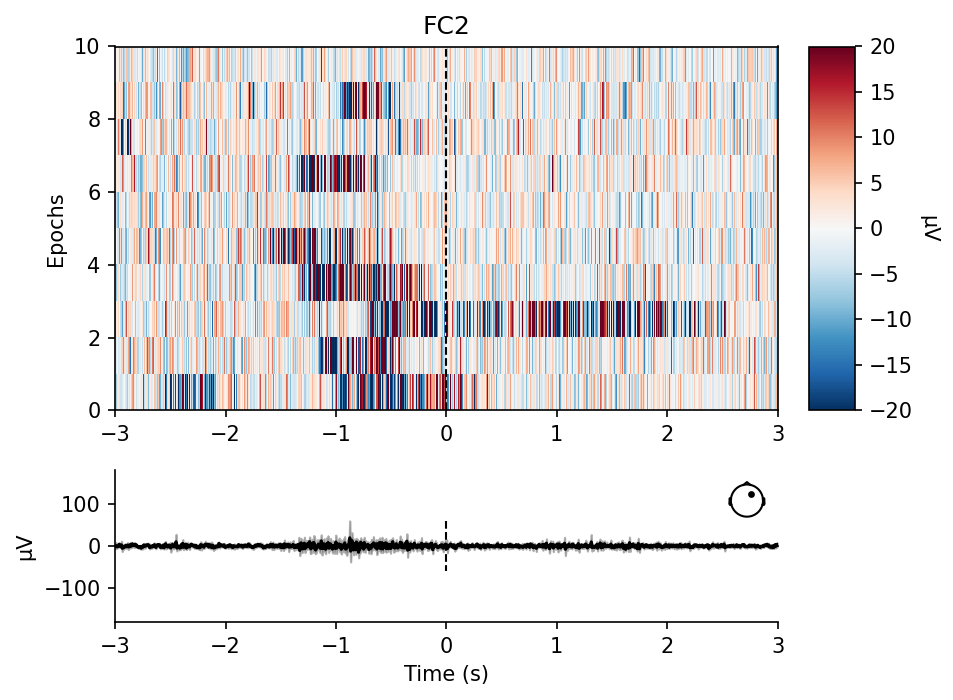

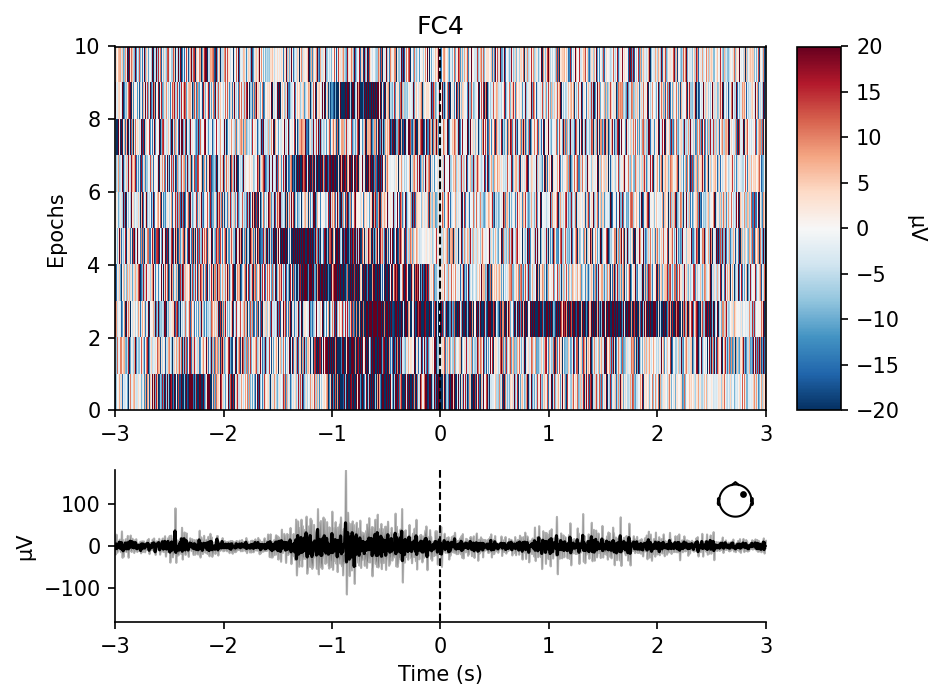

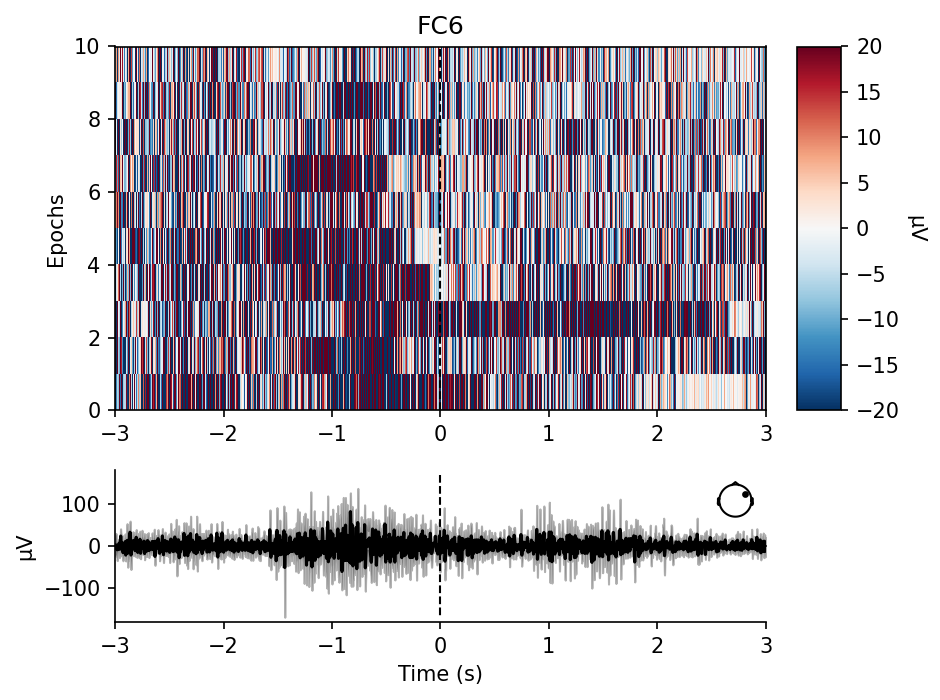

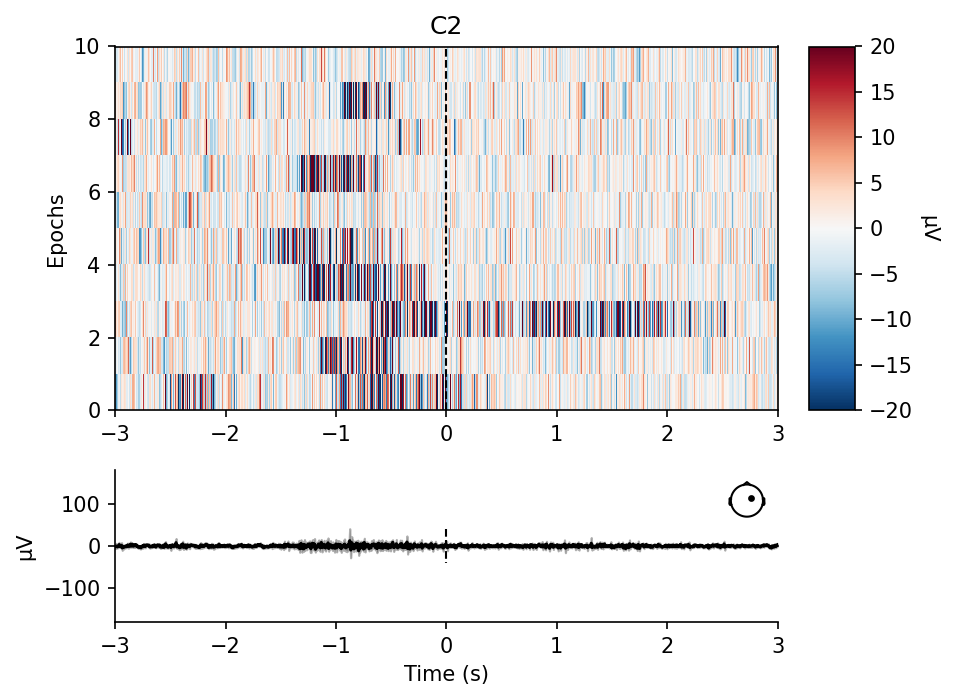

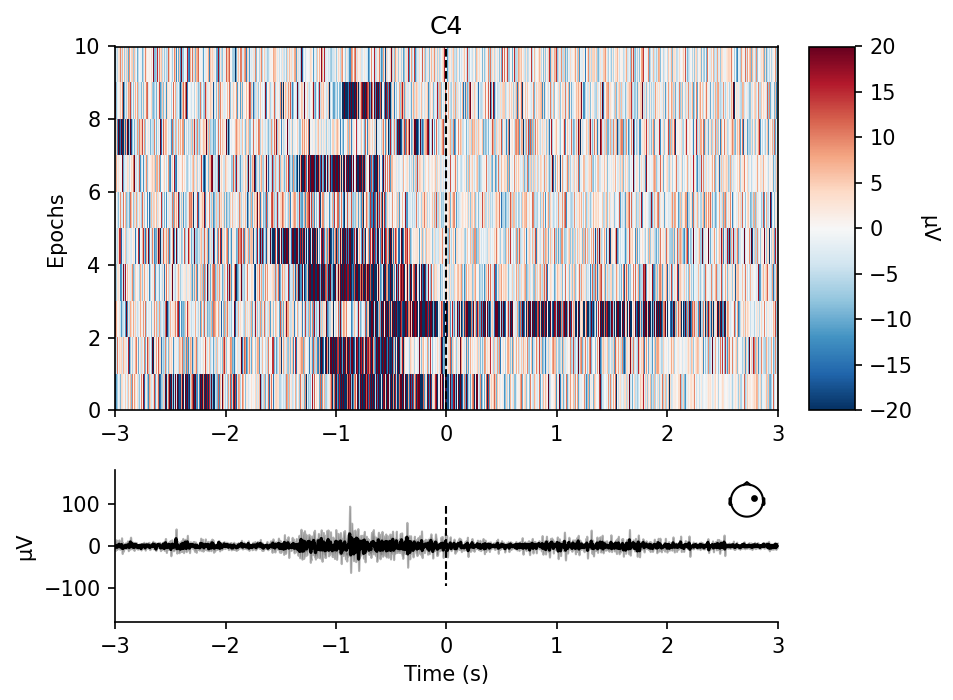

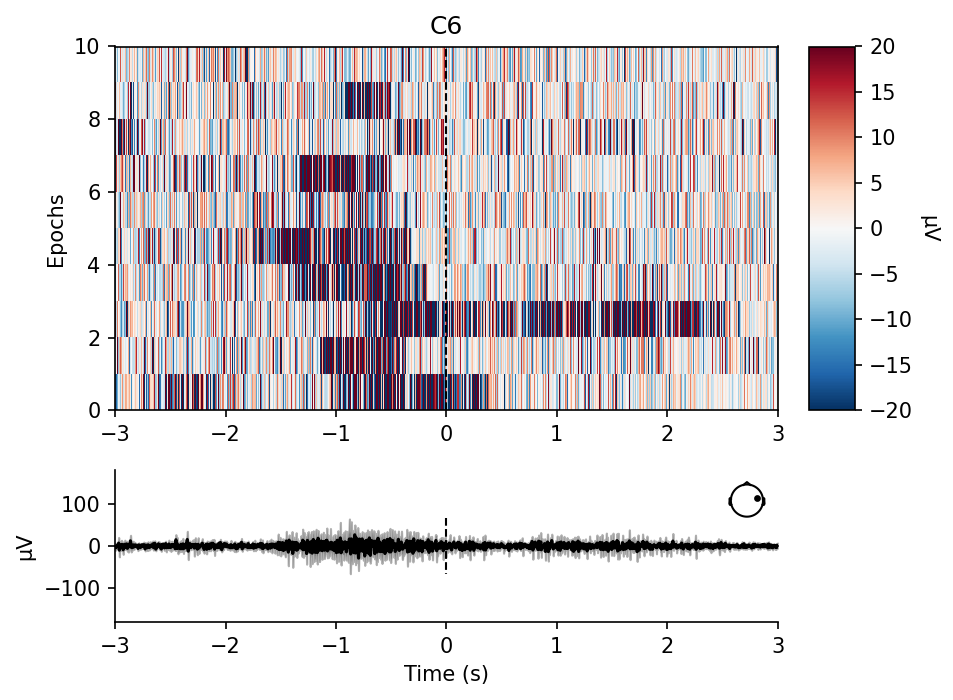

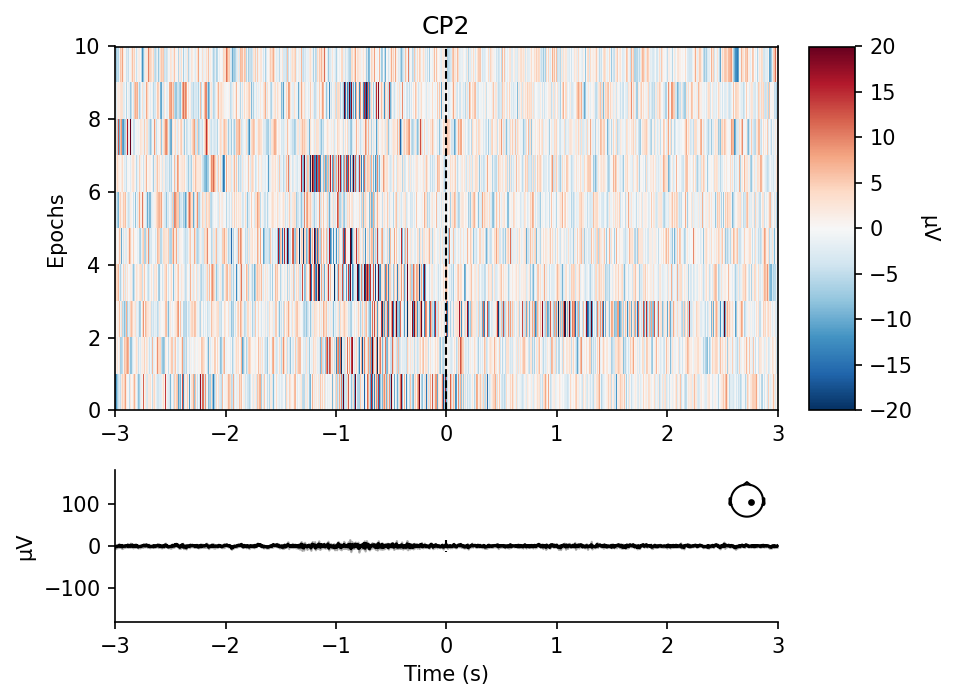

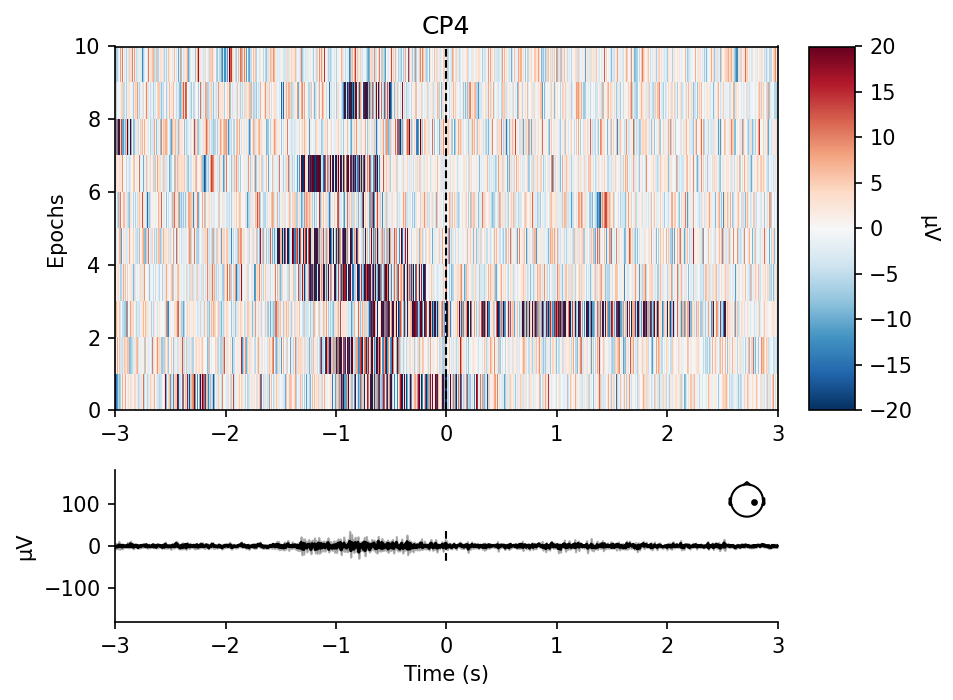

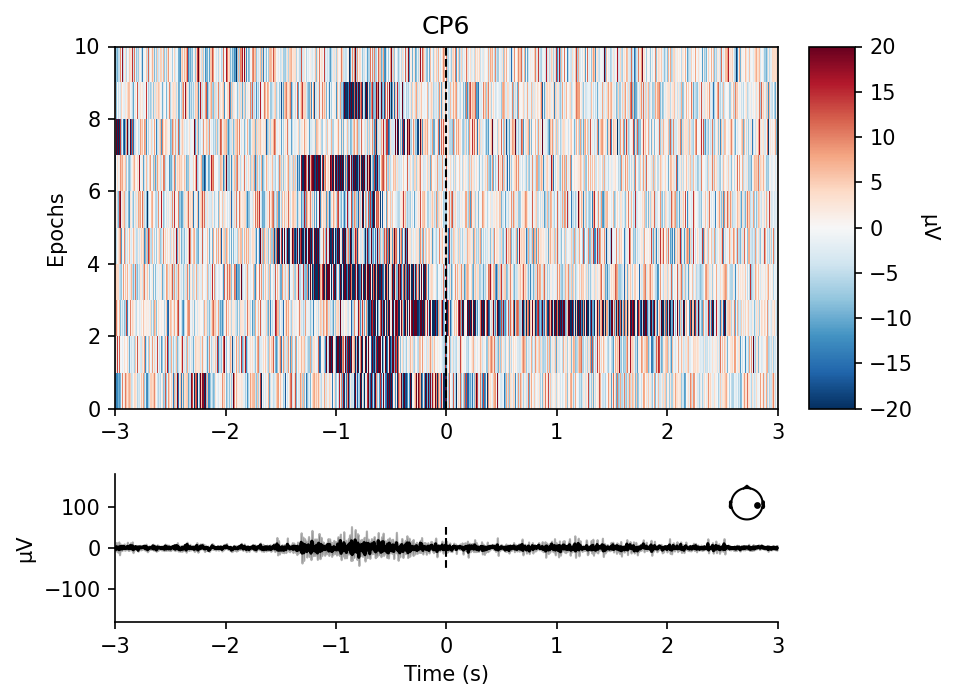

[<Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>,
 <Figure size 960x720 with 4 Axes>]

In [25]:
epochs_d["extension"].plot_image(picks=motor_electrods_d,
                               vmin = -20,
                               vmax = 20)

In [58]:
loader_trial.stroke_side

'G'

# Evoked data

La moyenne des signaux sur toutes les époques.

In [26]:
extension_g = epochs_g["extension"].average()
extension_d = epochs_d["extension"].average()

flexion_g = epochs_g["flexion"].average()
flexion_d = epochs_d["flexion"].average()


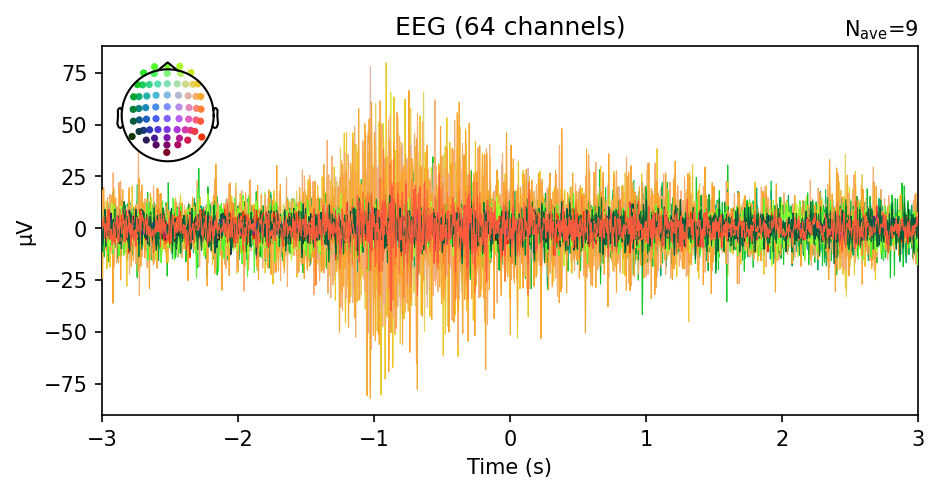

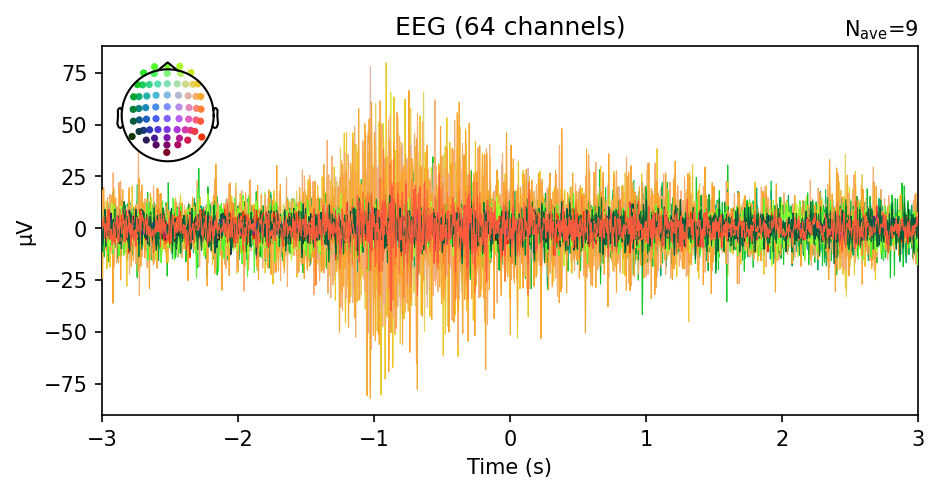

In [27]:
flexion_d.plot()

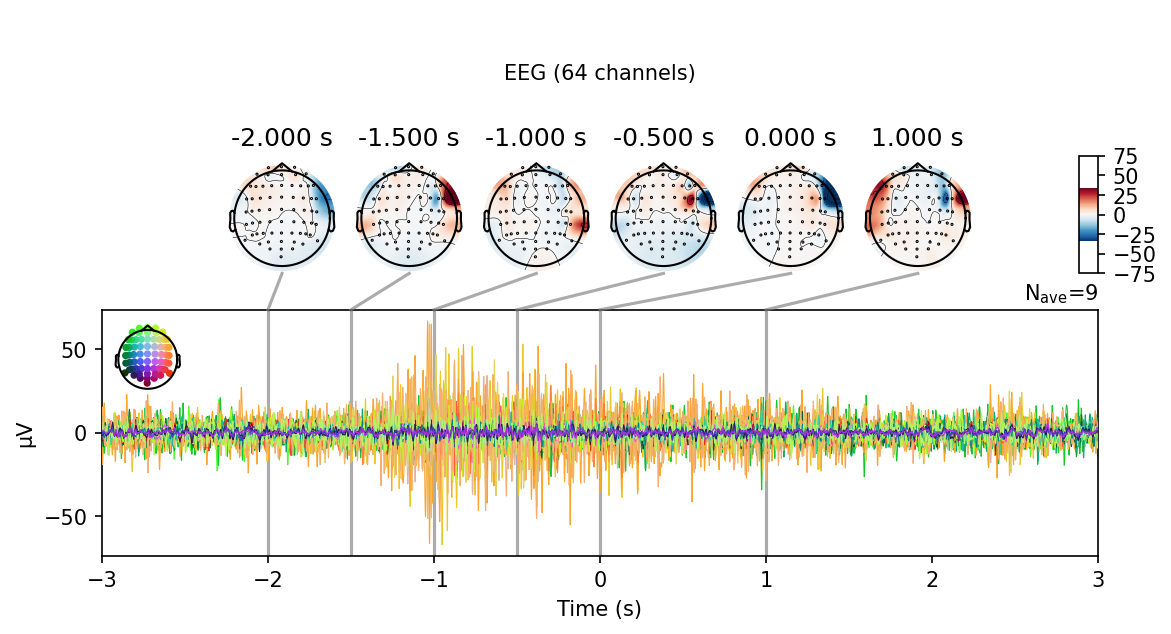

In [61]:
flexion_d.plot_joint(times = [-2,-1.5,-1,-0.5,0,1]);

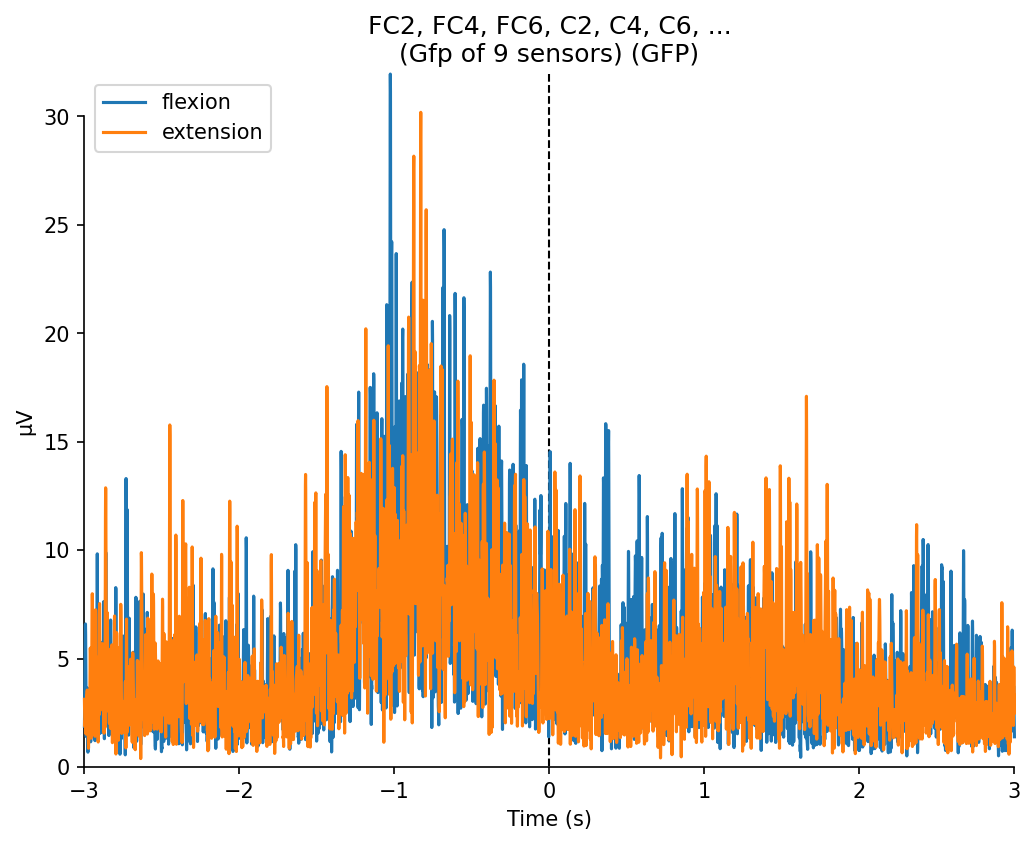

[<Figure size 1200x900 with 1 Axes>]

In [28]:
mne.viz.plot_compare_evokeds({"flexion":flexion_d,
                              "extension":extension_d},
                            picks = motor_electrods_d)

# Analyse fréquentielle

In [30]:
from mne.time_frequency import tfr_morlet

c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\mne\viz\utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


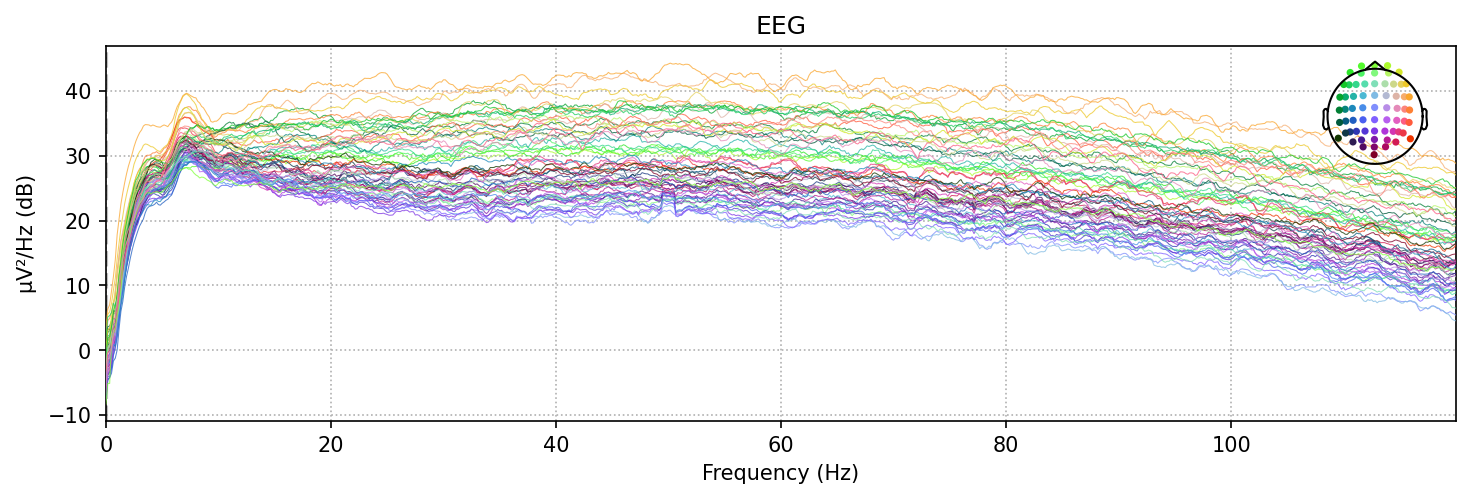

In [31]:
epochs_g.copy().plot_psd(fmin=0, fmax=120)

In [32]:
freqs = list(range(2,40))
tfr_flexion = tfr_morlet(epochs_g["flexion"], freqs, 2, return_itc = False)
tfr_extension = tfr_morlet(epochs_g["extension"], freqs, 2, return_itc = False)

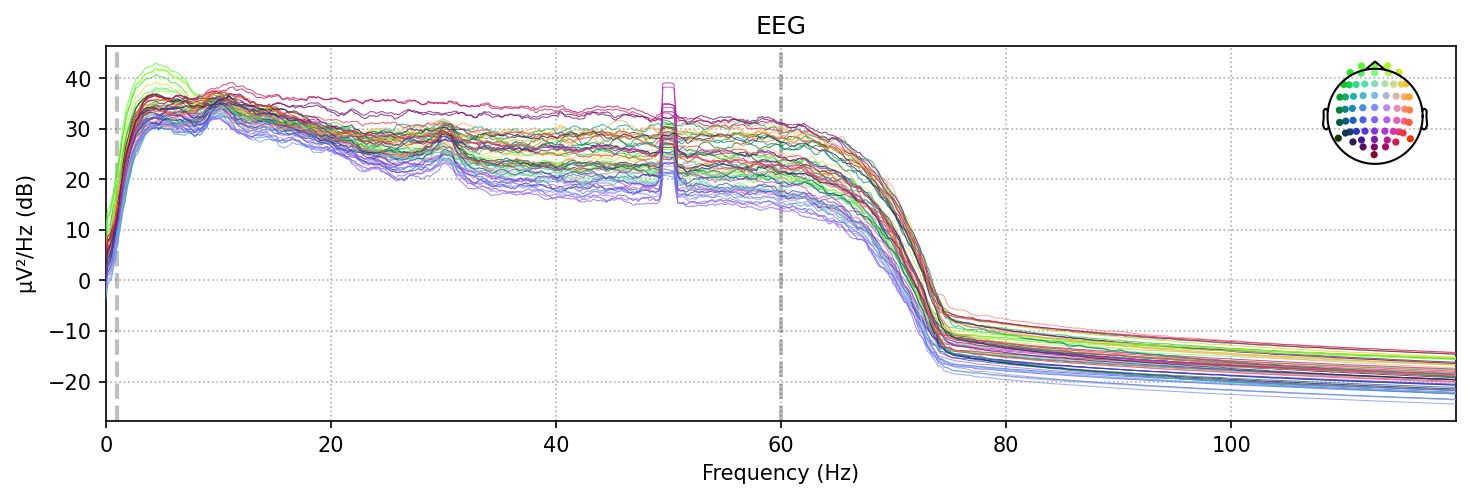

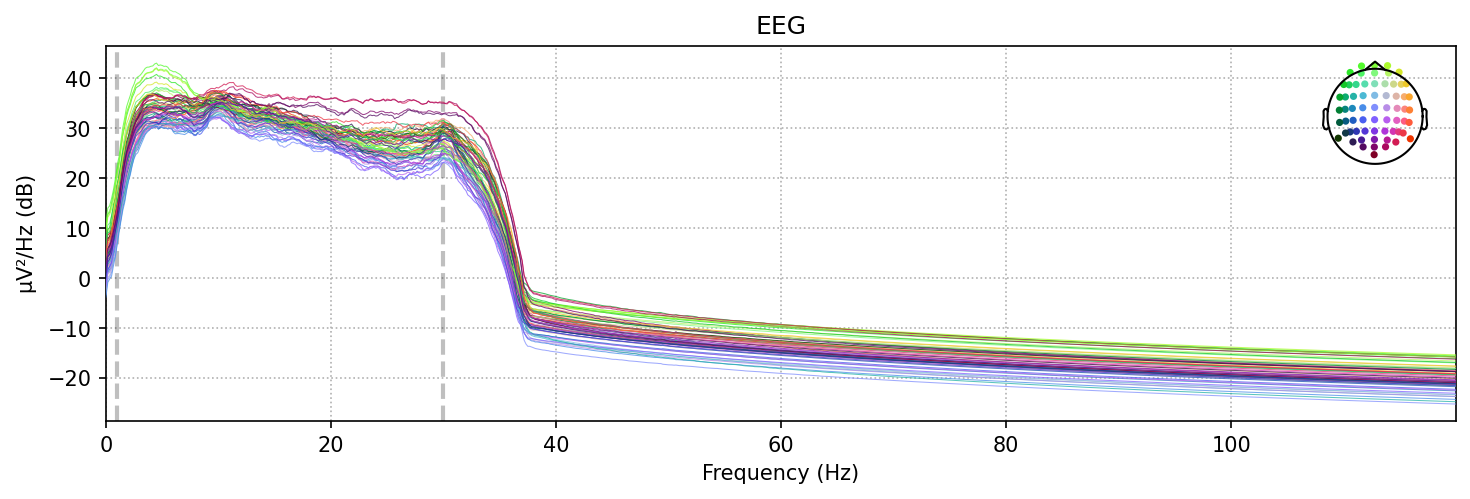

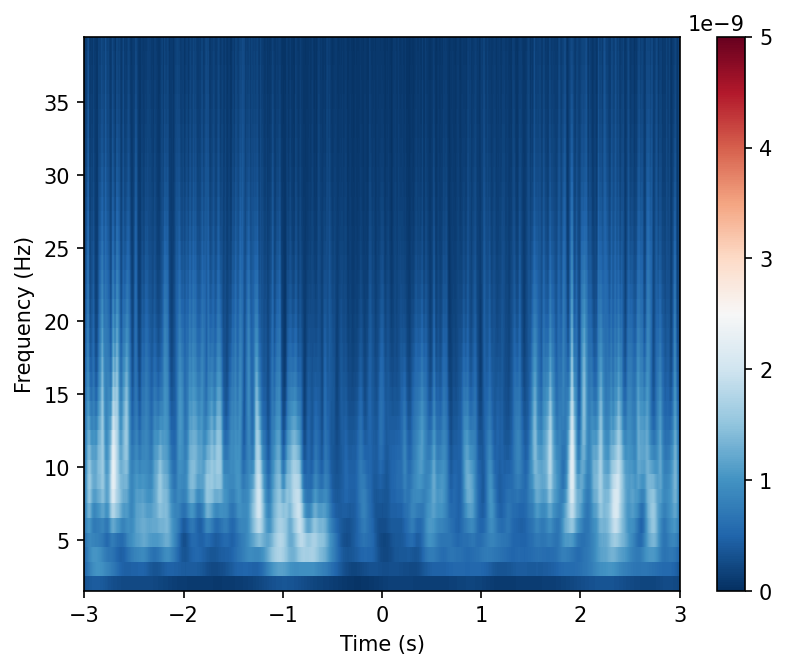

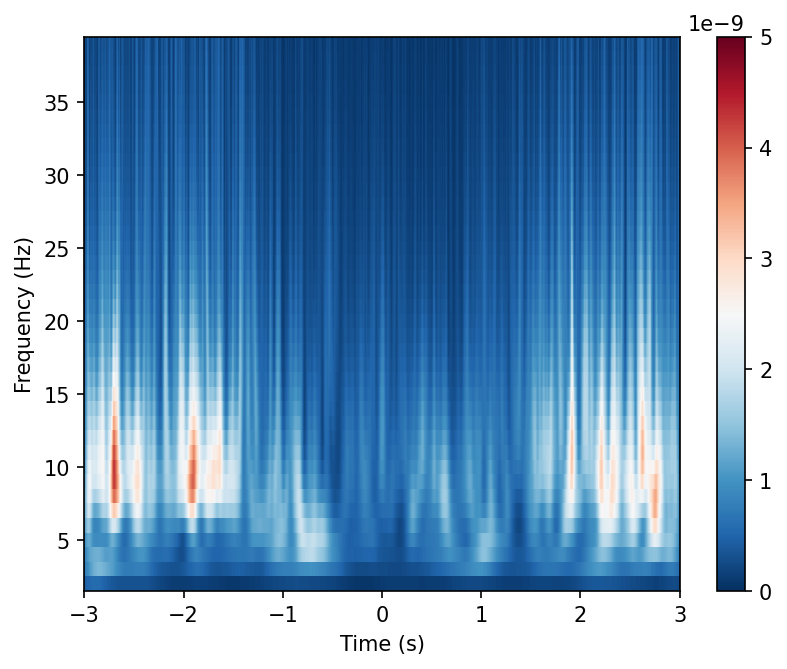

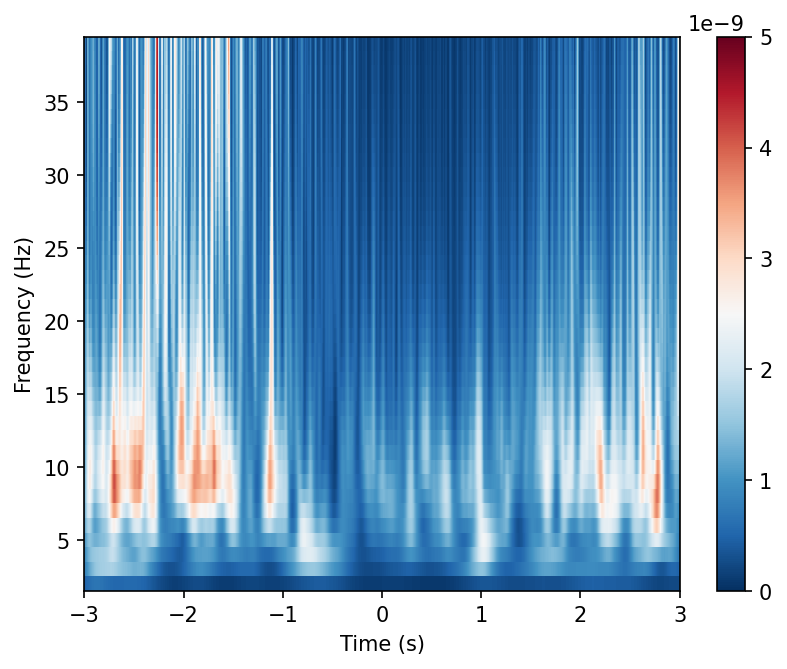

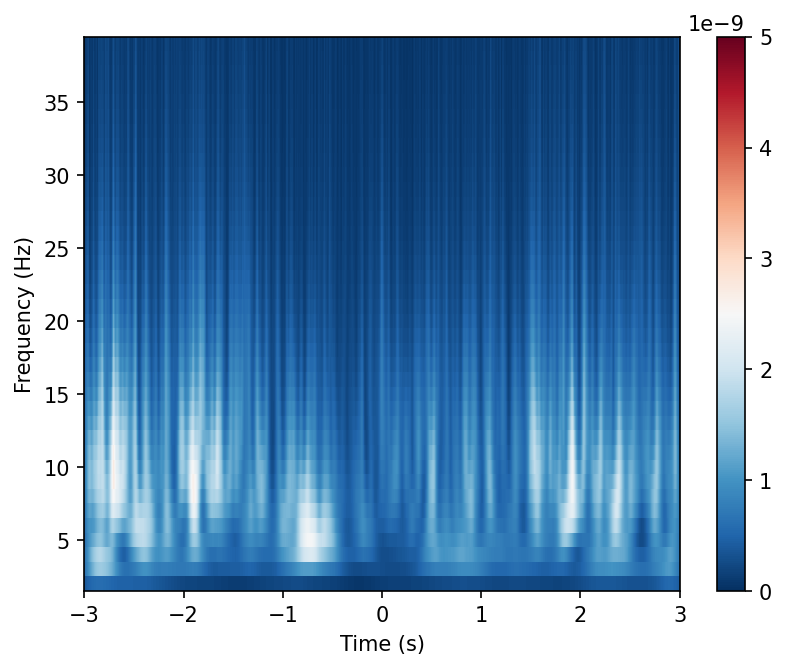

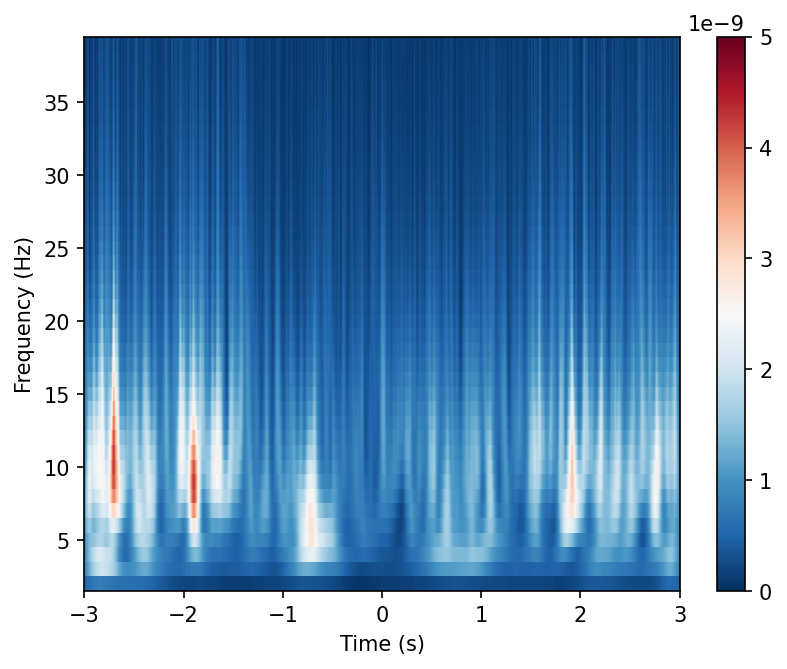

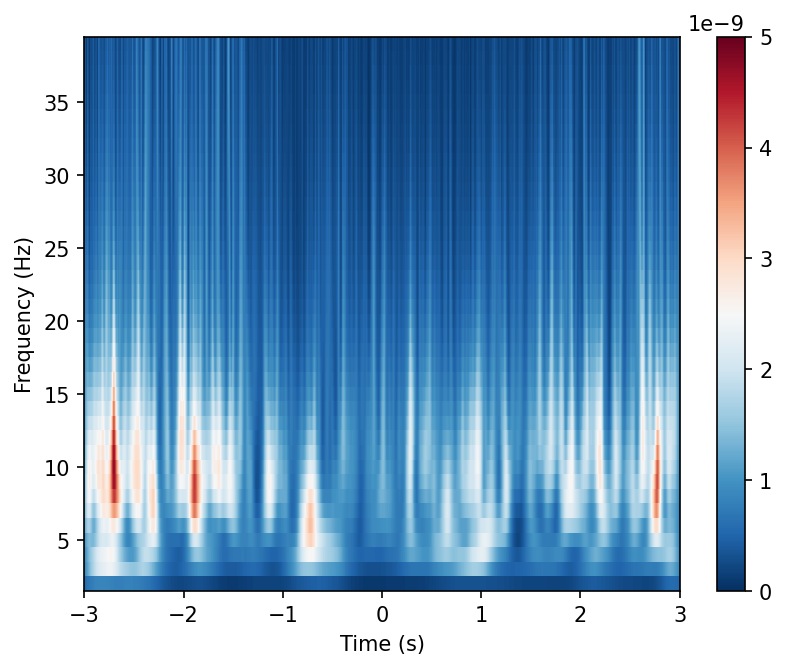

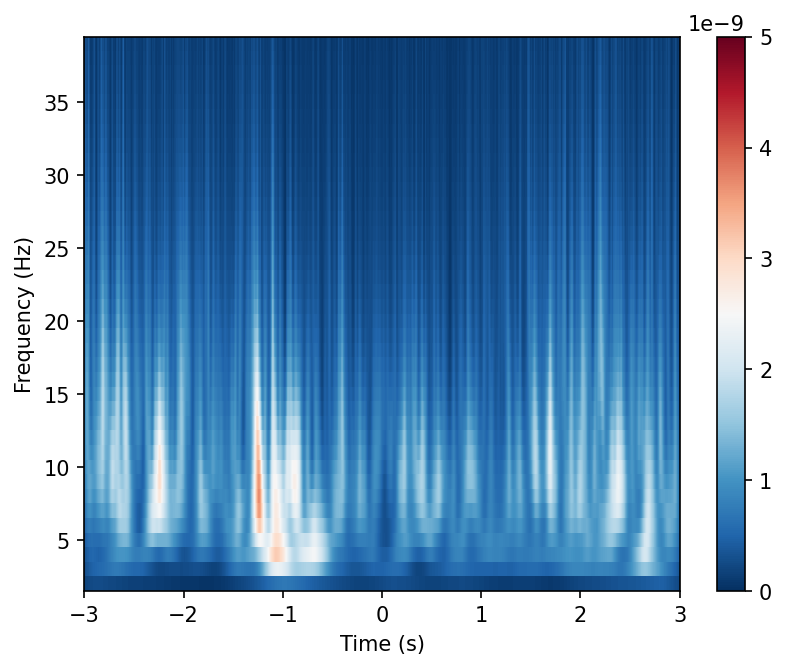

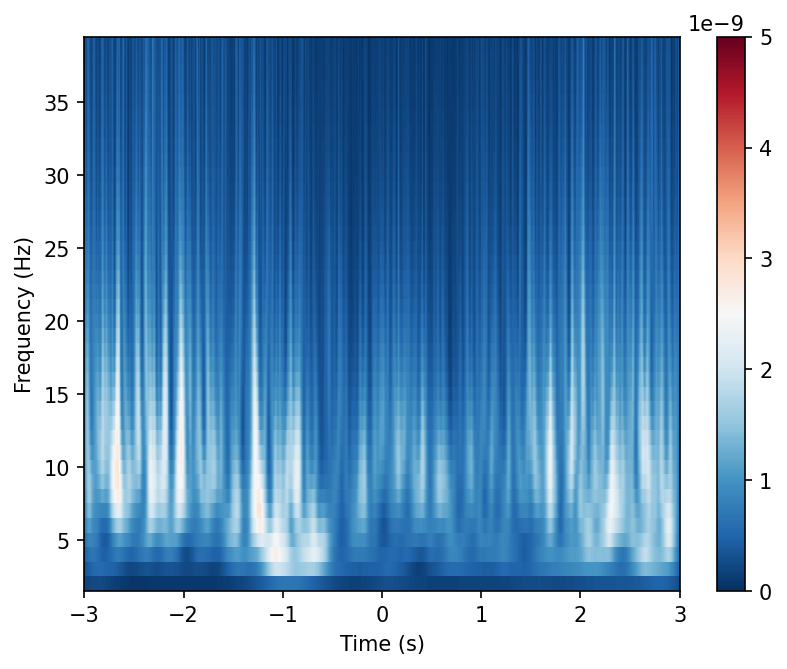

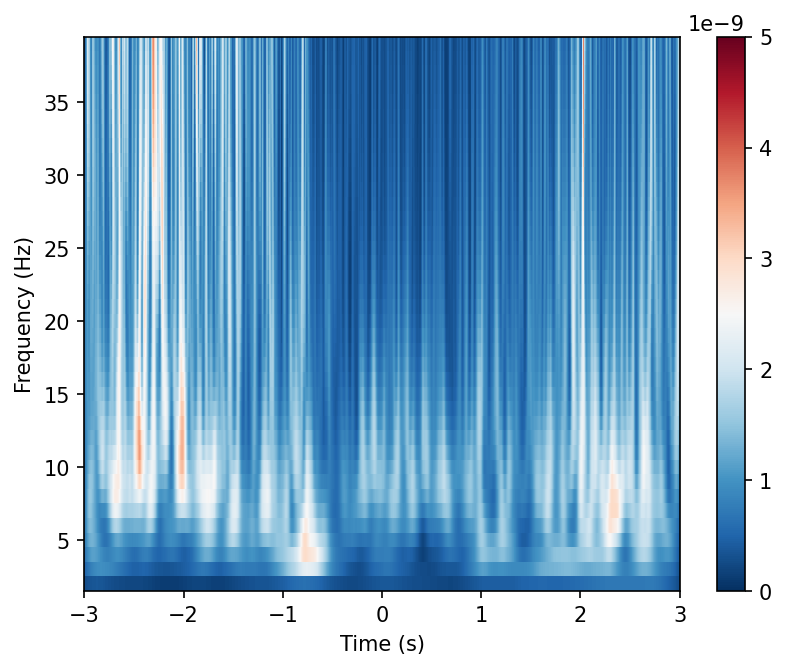

[<Figure size 960x720 with 2 Axes>,
 <Figure size 960x720 with 2 Axes>,
 <Figure size 960x720 with 2 Axes>,
 <Figure size 960x720 with 2 Axes>,
 <Figure size 960x720 with 2 Axes>,
 <Figure size 960x720 with 2 Axes>,
 <Figure size 960x720 with 2 Axes>,
 <Figure size 960x720 with 2 Axes>,
 <Figure size 960x720 with 2 Axes>]

In [313]:
tfr_extension.plot(picks=motor_electrods_d,vmin=0,vmax=5e-9)

### Chargement des données en utilisant la nouvelle structure.


In [42]:
NUMBER_OF_SESSIONS = 10

# Fréquence de filtrage
FMIN = 1
FMAX = 40

# Bornes époques
EPOCHS_TMIN = -1
EPOCHS_TMAX = 2

# temps depuis le mouvement pour époquer autours d'une plage sans mouvement
EPOCHS_EMPTY_FROM_MVT_TMINS = -4

BINARY_CLASSIFICATION = True

RANDOM_STATE = 42
N_SPLIT = 4

FOLDER_PATH = './../../data/raw/'
FILE_PATH_LIST = [FOLDER_PATH + file_path for file_path in os.listdir(FOLDER_PATH) if file_path.endswith('.npy')]

def get_channels(raws, side):
    endings = ('1', '3', '5', '7', '9') if side=='D' else ('2', '4', '6', '8', '10')
    channels_to_remove = [channel for channel in raws.ch_names if channel.endswith(endings)]
    channels = [channel for channel in raws.ch_names if channel not in channels_to_remove]
    return channels


import tqdm

def preproc(file_path_list, verbose=False):
    # structure data_patients = [session1, session2, ...]            dtype = list
    # structure data_session  = [epoch1, epoch2, ...]                dtype = np.array
    # structure epoch         = np.array([channel1, channel2, ...])  dtype = np.array
    # structure channel       = np.array([time1, time2, ...])        dtype = float

    # structure labels_patients     = [session1, session2, ...]            dtype = list
    # structure labels_session      = [label_epoch1, label_epoch2, ...]    dtype = int (0, 1, 2)

    data_patients = []
    labels_patients = []

    patients_id = []
    sessions_id = []

    for file in tqdm.tqdm(file_path_list):

        # loading data / auto labeling behind the scene
        data_loader = DataLoader(file)

        # picking the arm session opposite to the stroke side
        stroke = data_loader.stroke_side
        arm_side = 'G' if stroke == 'D' else 'G'
        raws = data_loader.get_raws(side=arm_side)
        
        # if no data for the arm side, we skip the session
        if raws is None:
            continue

        # picking channels of only the stroke side
        raws.pick_channels(get_channels(raws, stroke))

        # filtering
        raws.filter(FMIN, FMAX, fir_design='firwin')

        # creating epochs over flexion and extension of the arm (movement)
        events = mne.find_events(raws, stim_channel=['movement'])
        picks = mne.pick_types(raws.info, eeg=True, stim=False)
        epochs = mne.Epochs(raws, events, tmin=EPOCHS_TMIN, tmax=EPOCHS_TMAX, picks=picks, baseline=None, preload=True)
        epochs_data_mvt = epochs.get_data()
        label_mvt = epochs.events[:, -1]

        # creating artificial epoch when no movement
        epochs_no_mvt = mne.Epochs(raws, events, tmin=EPOCHS_EMPTY_FROM_MVT_TMINS, tmax=EPOCHS_EMPTY_FROM_MVT_TMINS+EPOCHS_TMAX-EPOCHS_TMIN, 
                                    picks=picks, baseline=None, preload=True)
        epochs_data_no_mvt = epochs_no_mvt.get_data()
        labels_no_mvt = np.zeros(epochs_data_no_mvt.shape[0])

        # concatenating epochs
        epochs_data_session = np.concatenate((epochs_data_mvt, epochs_data_no_mvt), axis=0)
        labels_session = np.concatenate((label_mvt, labels_no_mvt), axis=0)

        # Shuffling epochs
        random_state = np.random.RandomState(RANDOM_STATE)
        indices = np.arange(epochs_data_session.shape[0])
        random_state.shuffle(indices)
        epochs_data_session = epochs_data_session[indices]
        labels_session = labels_session[indices]

        # if binary classification, we merge flexion and extension
        if BINARY_CLASSIFICATION:
            labels_session[labels_session != 0] = 1

        # adding session data and session labels to data_patients and labels_patients (if new patient, add new list)
        if data_loader.patient_id not in patients_id:
            patients_id.append(data_loader.patient_id)
            sessions_id.append([])
            data_patients.append([])
            labels_patients.append([])
        sessions_id[patients_id.index(data_loader.patient_id)].append(data_loader.session_id)
        data_patients[patients_id.index(data_loader.patient_id)].append(epochs_data_session)
        labels_patients[patients_id.index(data_loader.patient_id)].append(labels_session)

        if verbose:
            print(f'patient id: {data_loader.patient_id}')
            print(f'session id: {data_loader.session_id}')
            print(f'number of epochs: {epochs_data_session.shape[0]}')
            print(f'number of channels: {epochs_data_session.shape[1]}')
            print(f'number of time samples: {epochs_data_session.shape[2]}')

    return data_patients, labels_patients, patients_id, sessions_id

